In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from skimage import io
import wandb

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

### Config

In [3]:
config = {
    "lr": 1e-5,
    "epochs_num": 15000,
    "batch_size": 64,
    "log_each": 20,
    "device": "cuda:2",
    "z_dim": 16,
    "disc_coef": 5
}

### Data

In [4]:
_DATA_DIR = '/home/pafakanov/data/hep_data/spacal_simulation/1GeV/fft_images'

class ImageDataset(Dataset):
    def __init__(self, data_dir=_DATA_DIR):
        self.data_dir = data_dir

    def __len__(self):
        return len(os.listdir(self.data_dir)) - 1

    def __getitem__(self, idx):
        img_path = self.get_image_path(idx)
        img = io.imread(img_path)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        return img_tensor.float() / 255.0
    
    @staticmethod
    def get_image_path(idx):
        return os.path.join(_DATA_DIR, str(idx)) + '.png'

In [5]:

                
dataset = ImageDataset()
dataloader = DataLoader(dataset, batch_size=config["batch_size"], \
                        shuffle=True)
dataloader = data_gen(dataloader)  

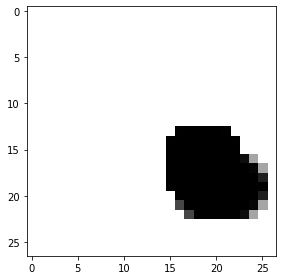

In [6]:
io.imshow(dataset.get_image_path(0))

### Models

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(5, 3)
        self.conv1 = nn.Conv2d(4, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)

        self.fc1 = nn.Linear(16 * 2 * 2, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x, debug=False):
        def _debug():
            if debug:
                print(x.shape)

        _debug()
        x = F.leaky_relu(self.conv1(x))
        _debug()
        x = self.pool(x)
        _debug()
        x = F.leaky_relu(self.conv2(x))
        _debug()
        x = self.pool(x)
        _debug()
        x = F.leaky_relu(self.conv3(x))
        _debug()

        x = x.view(-1, 16 * 2 * 2)
        _debug()
        x = F.leaky_relu(self.fc1(x))
        _debug()
        x = F.leaky_relu(self.fc2(x))
        _debug()
        return x

In [8]:
# discriminator = Discriminator(config)
# test_tensor = dataset[0].unsqueeze(0)
# discriminator(test_tensor, debug=True)

In [9]:
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.z_dim = config["z_dim"]
        
        self.fc1 = nn.Linear(self.z_dim, 64)
        self.fc2 = nn.Linear(64, 784)
        
        self.conv1 = nn.ConvTranspose2d(4, 16, 3, stride=2)
        self.conv2 = nn.ConvTranspose2d(16, 32, 3, stride=1)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.conv4 = nn.Conv2d(16, 4, 3)
        
    def forward(self, x, debug=False):
        def _debug():
            if debug:
                print(x.shape)

        _debug()
        x = F.leaky_relu(self.fc1(x))
        _debug()
        x = F.leaky_relu(self.fc2(x))
        _debug()

        x = x.view(-1, 4, 14, 14)
        _debug()
        x = F.leaky_relu(self.conv1(x))
        _debug()
        x = F.leaky_relu(self.conv2(x))
        _debug()
        x = F.leaky_relu(self.conv3(x))
        _debug()
        x = F.leaky_relu(self.conv4(x))
        _debug()
        return x

In [10]:
# generator = Generator(config)
# test_z = torch.rand(config['batch_size'], config['z_dim'])
# output = generator(test_z, debug=True)

### Training

In [11]:
from torch.autograd import Variable

In [12]:
wandb.init(config=config, project="hep_generative_models")

generator = Generator(config)
discriminator = Discriminator(config)

generator.to(config["device"])
discriminator.to(config["device"])

wandb.watch(generator)
wandb.watch(discriminator)

G_optimizer = torch.optim.Adam(generator.parameters(), lr=config['lr'])
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['lr'])


wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.1
wandb: Run data is saved locally in wandb/run-20200923_154616-36c24gjd
wandb: Syncing run bright-sunset-106


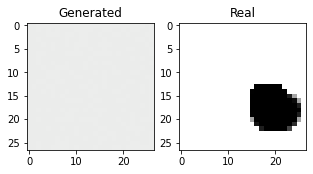

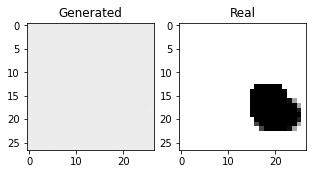

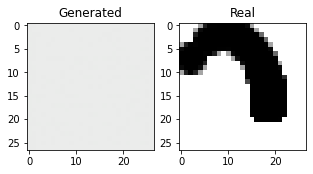

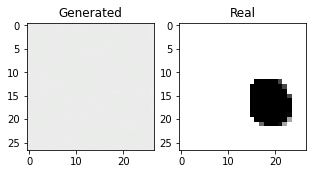

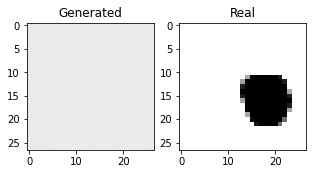

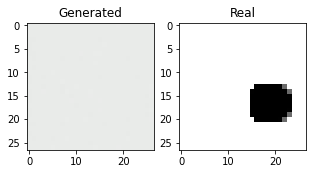

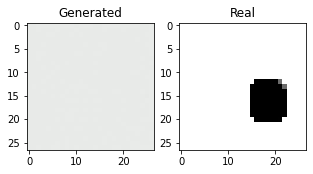

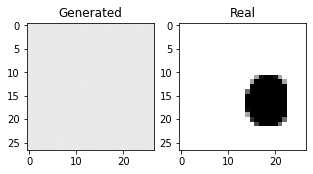

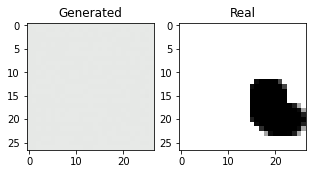

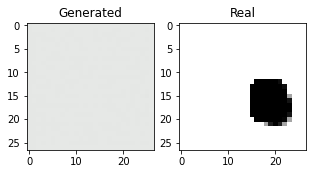

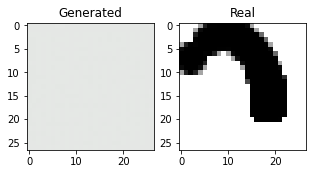

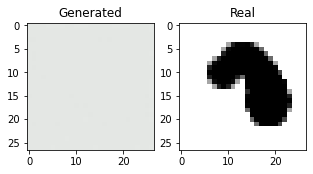

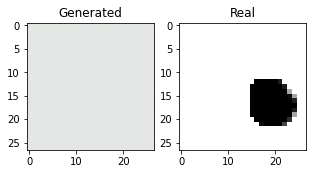

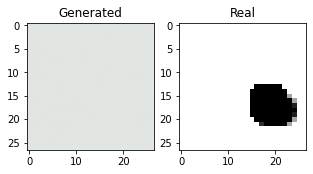

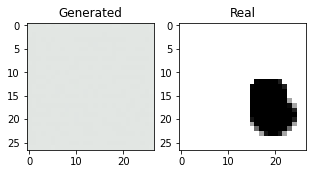

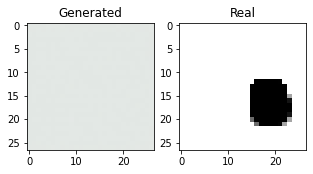

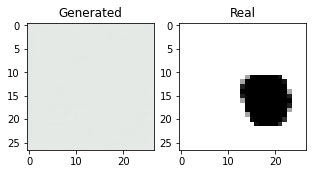

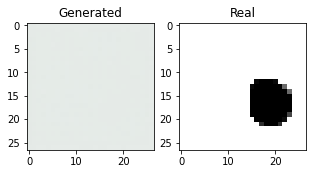

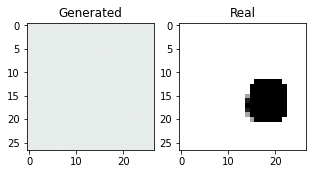

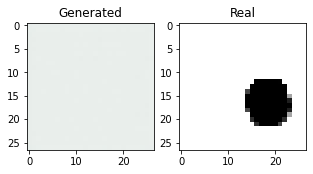

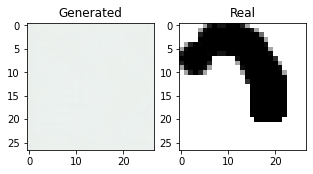

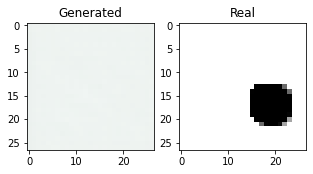

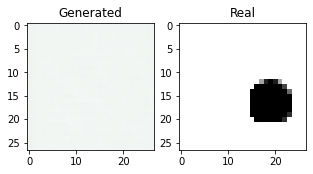

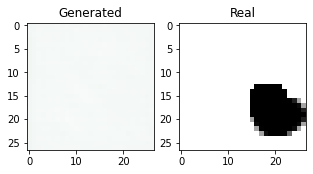

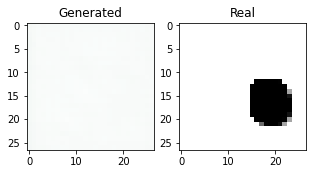

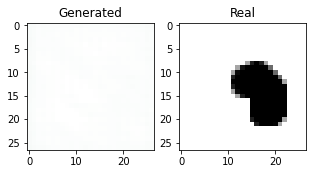

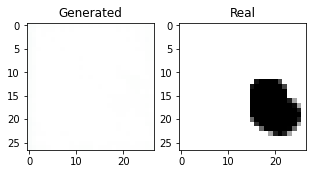

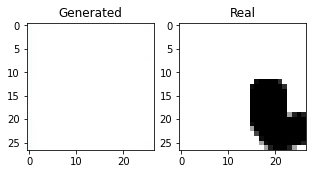

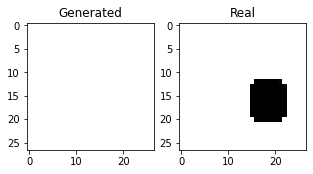

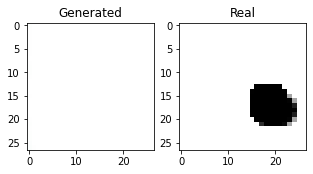

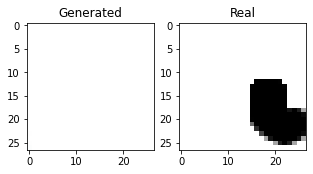

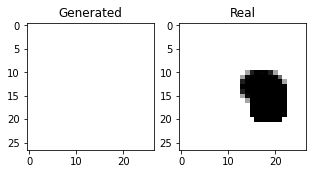

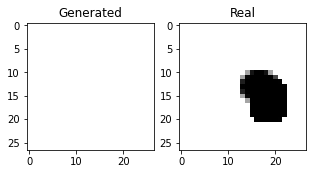

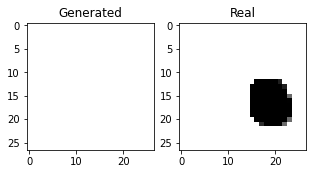

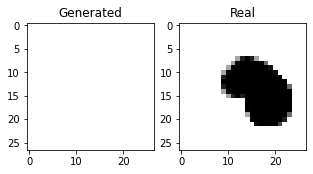

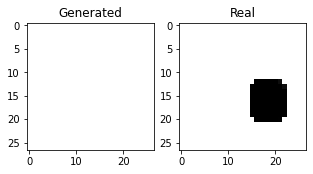

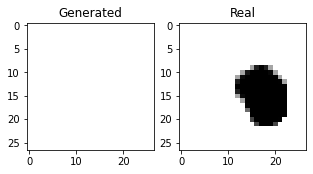

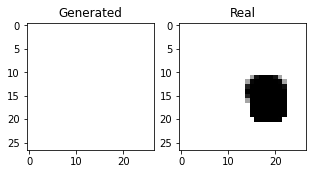

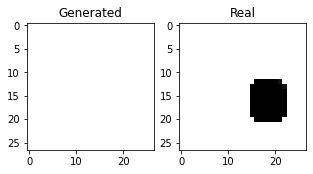

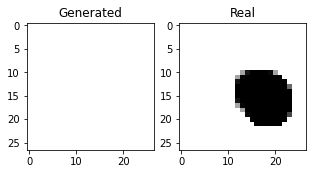

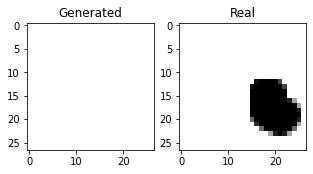

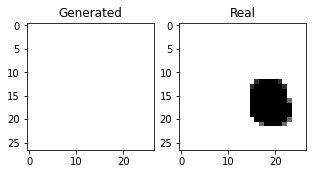

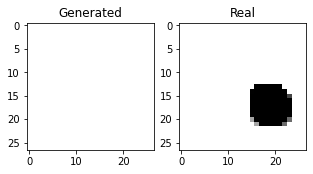

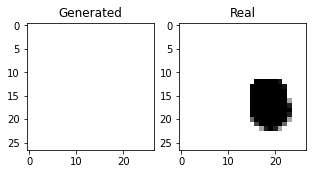

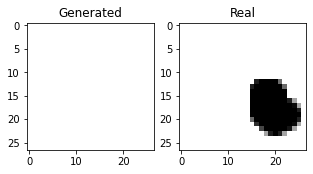

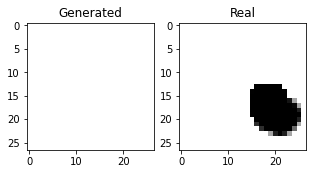

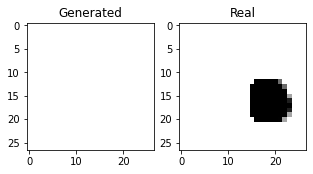

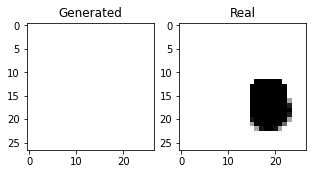

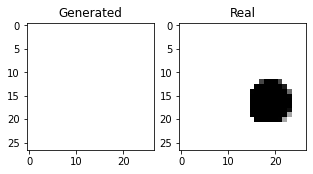

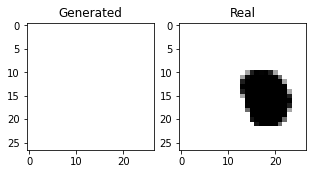

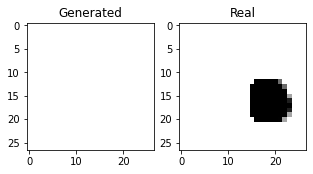

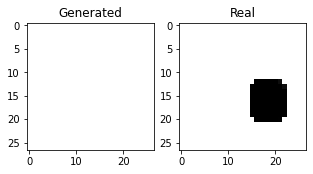

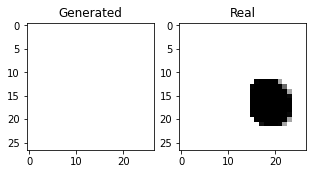

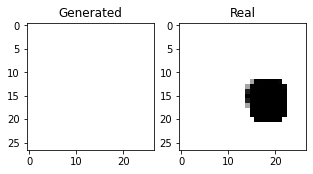

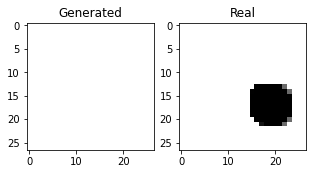

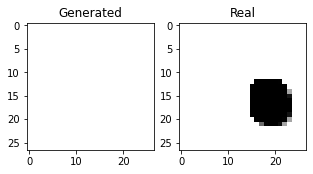

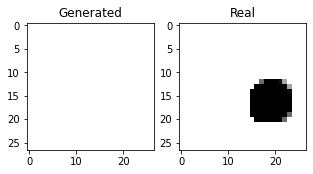

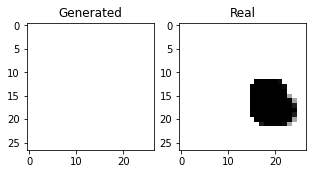

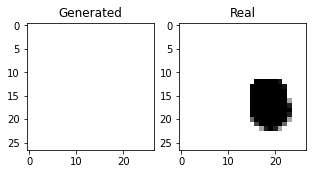

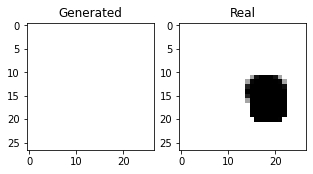

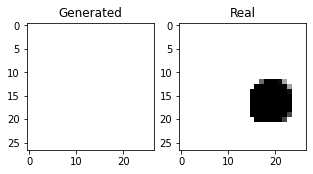

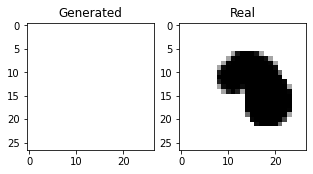

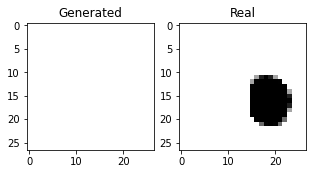

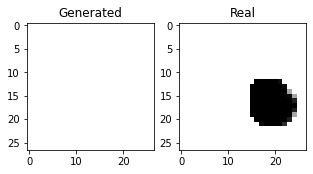

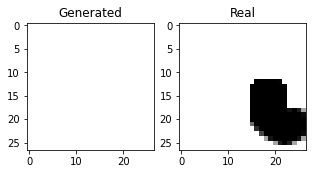

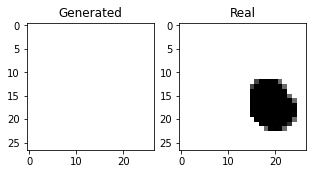

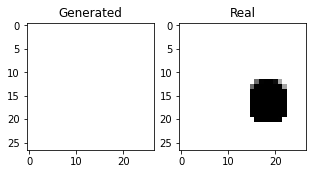

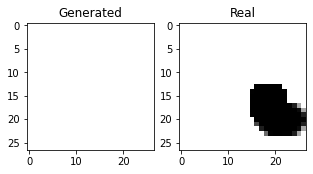

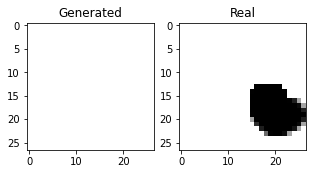

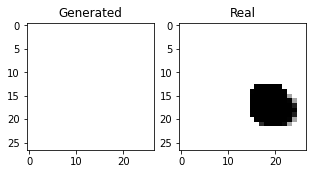

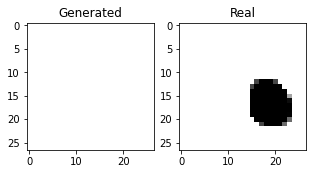

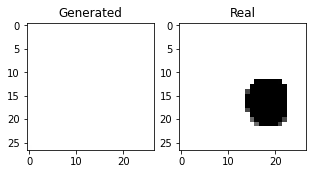

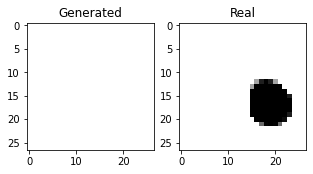

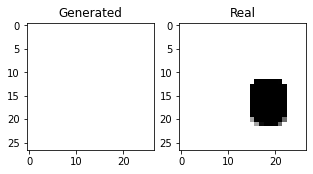

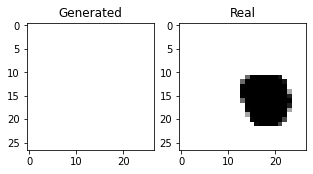

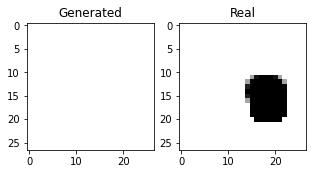

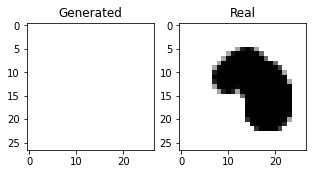

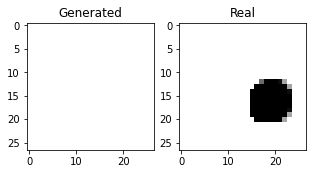

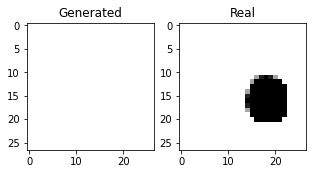

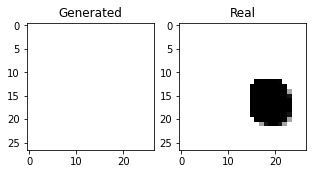

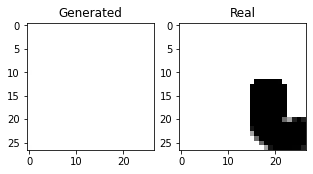

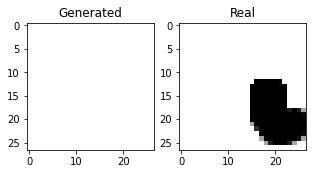

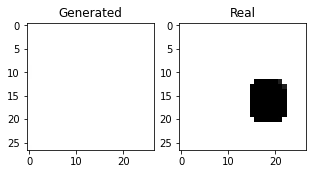

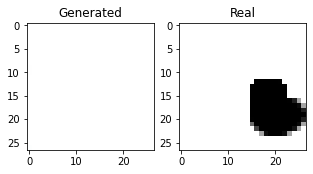

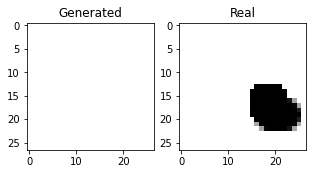

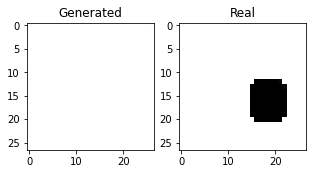

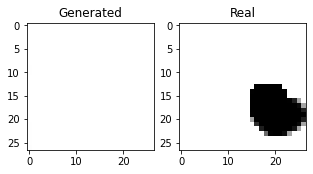

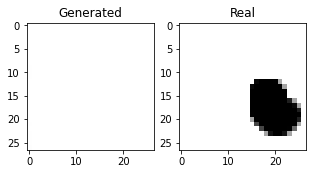

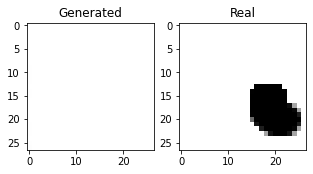

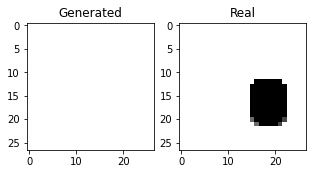

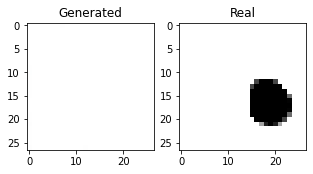

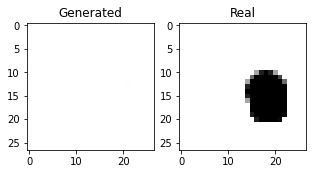

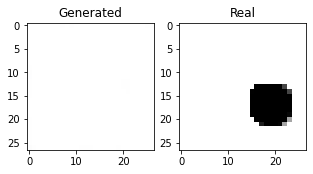

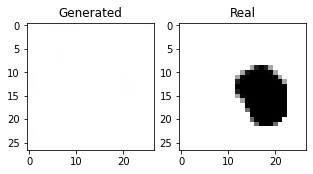

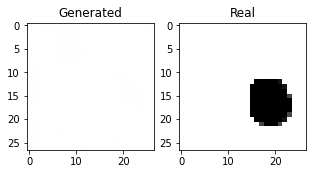

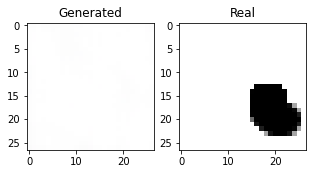

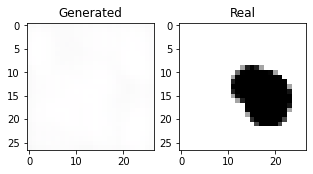

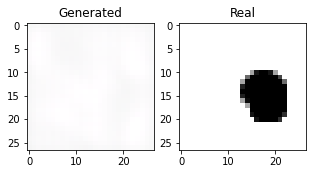

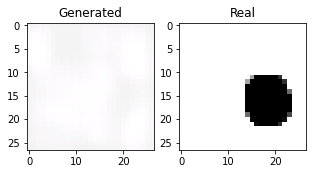

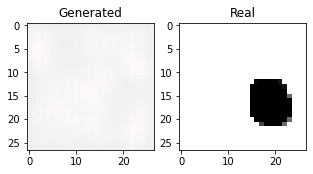

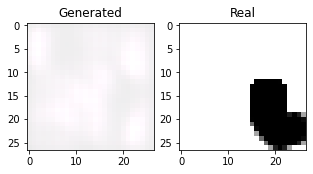

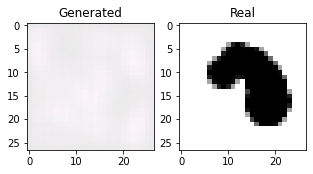

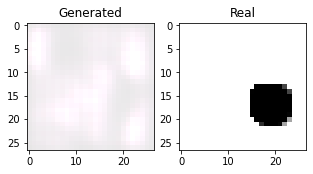

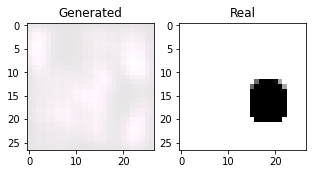

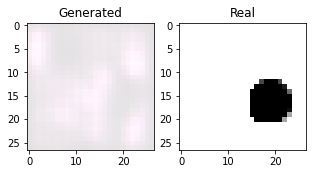

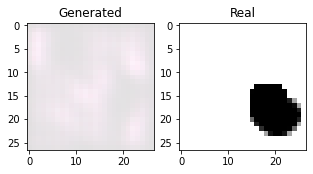

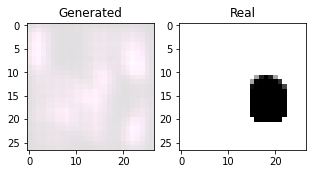

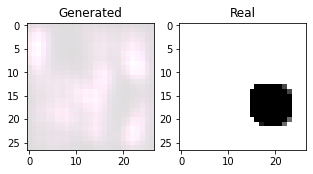

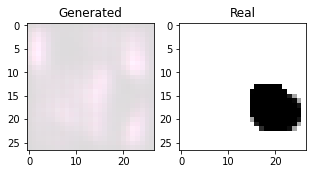

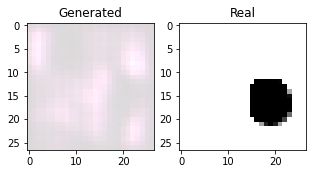

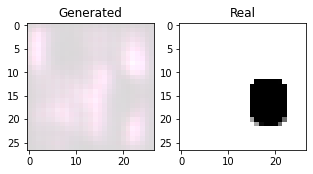

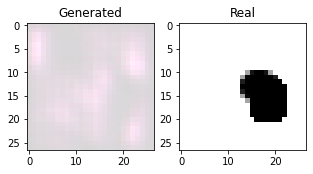

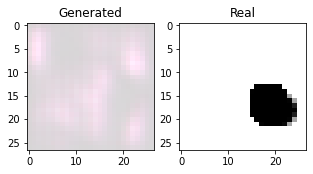

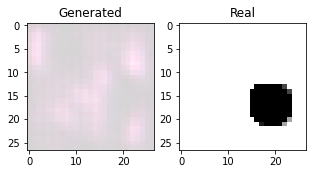

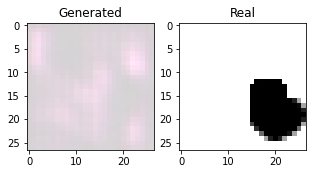

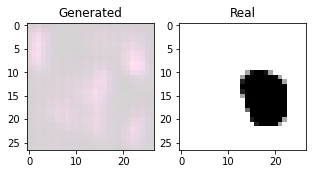

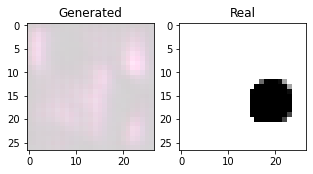

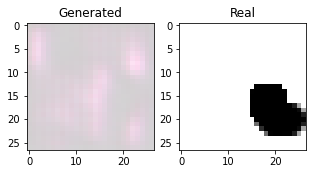

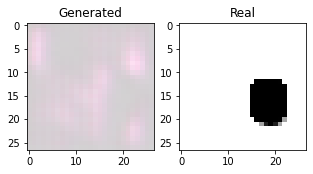

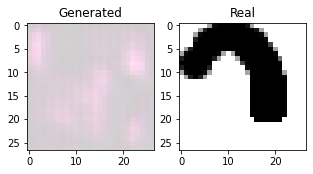

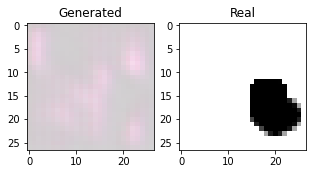

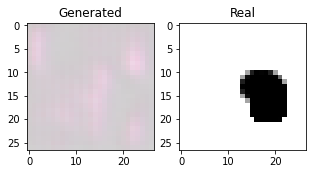

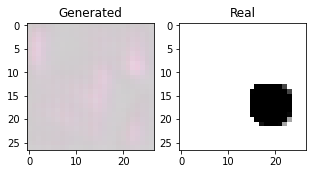

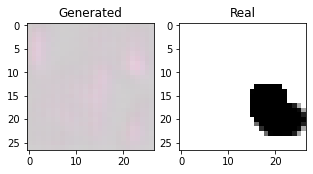

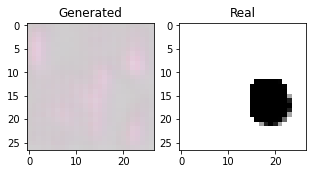

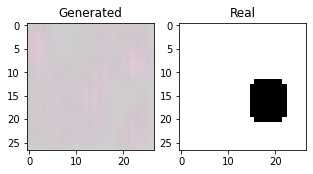

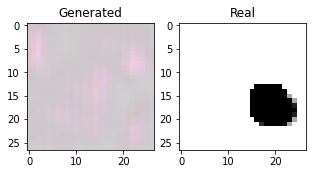

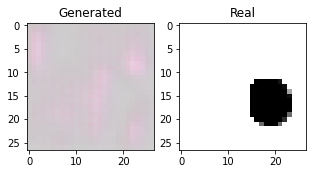

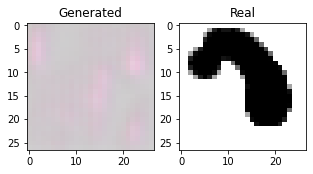

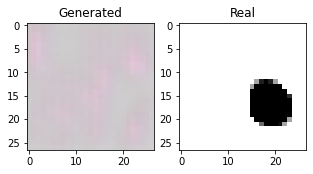

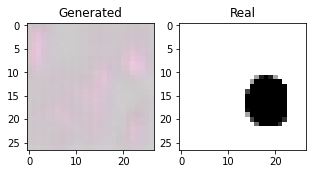

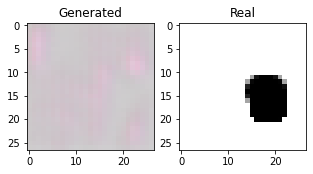

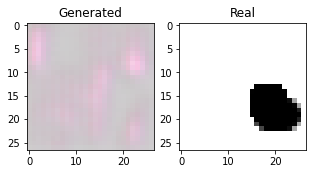

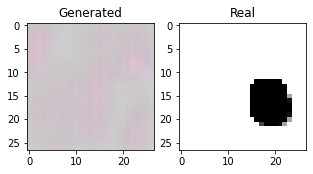

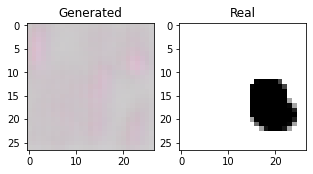

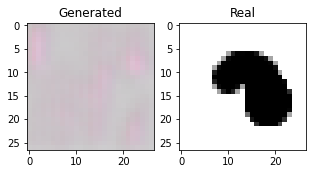

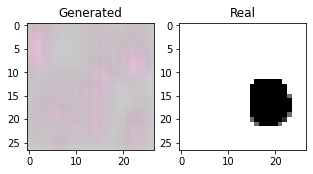

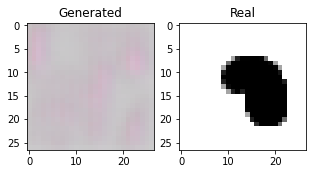

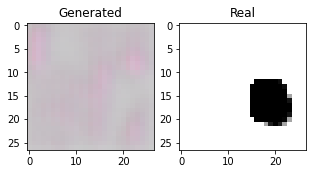

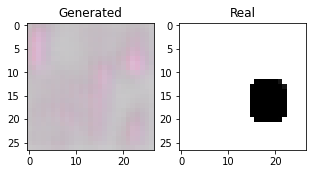

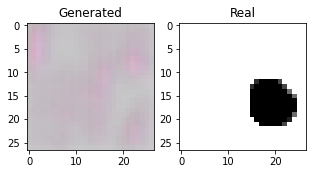

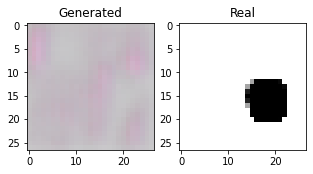

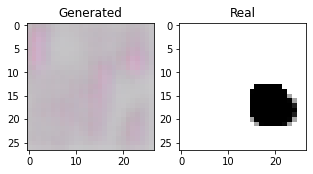

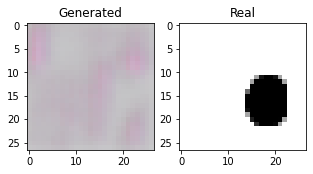

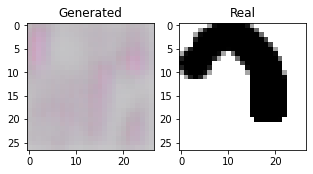

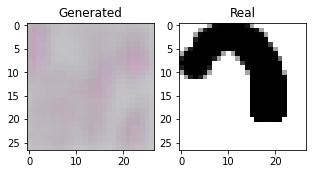

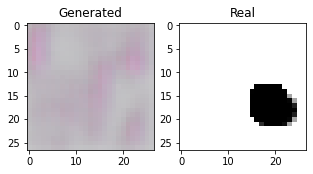

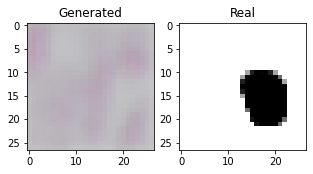

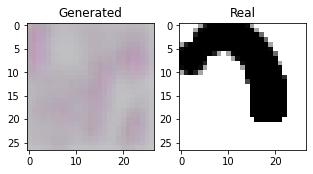

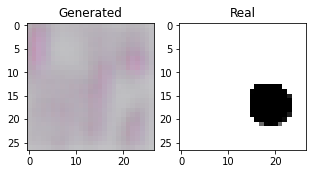

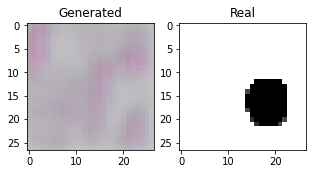

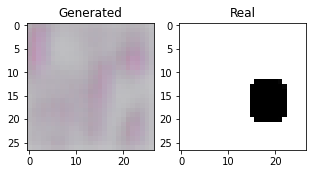

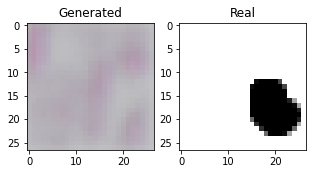

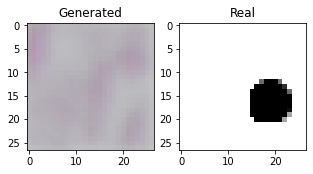

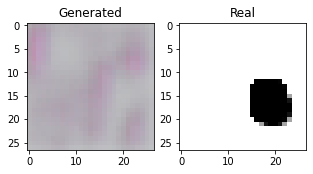

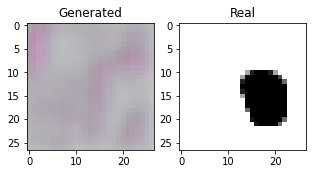

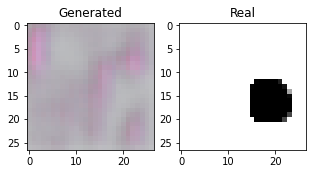

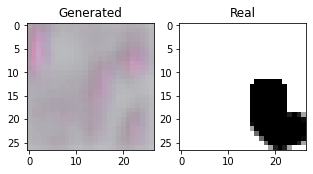

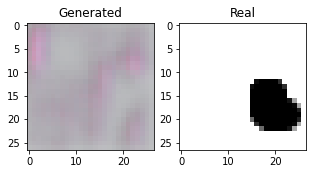

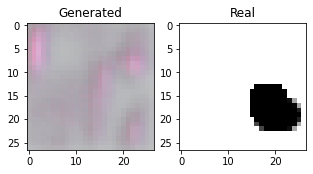

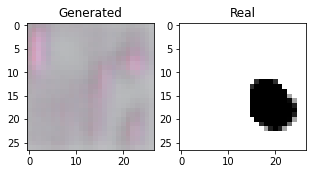

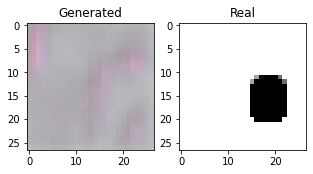

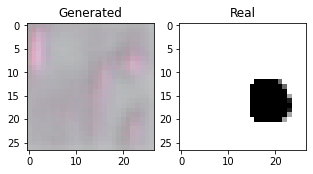

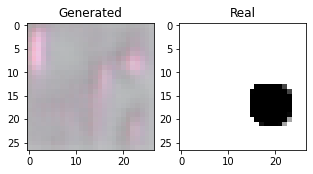

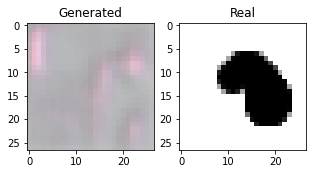

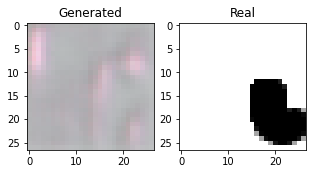

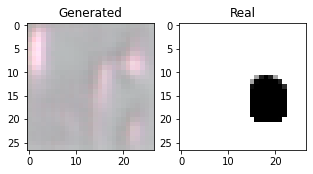

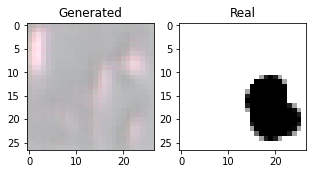

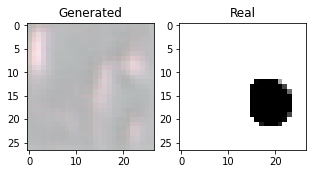

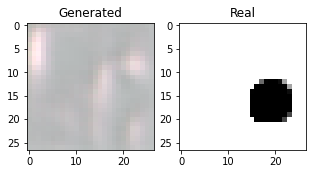

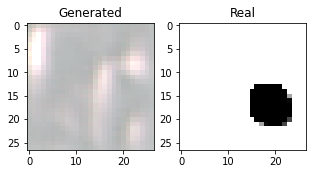

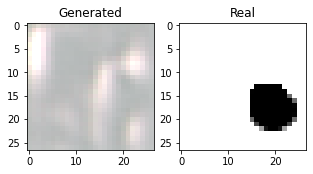

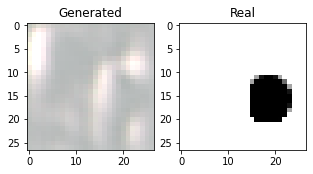

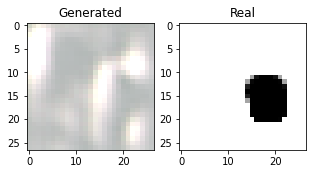

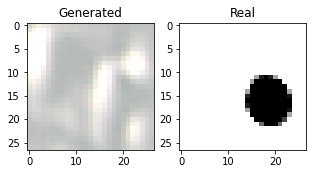

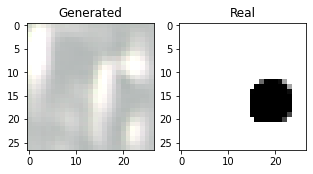

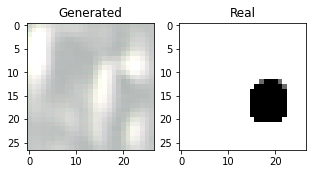

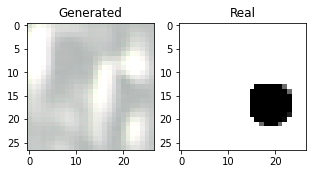

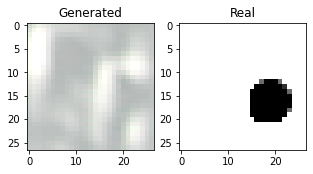

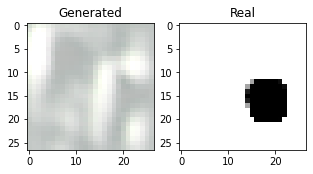

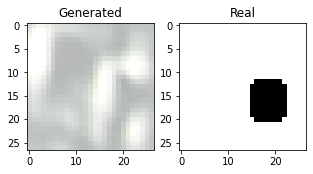

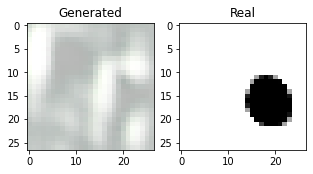

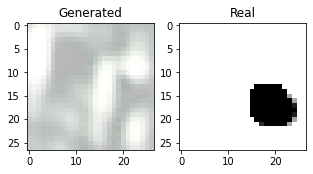

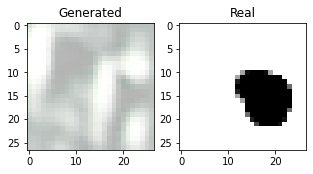

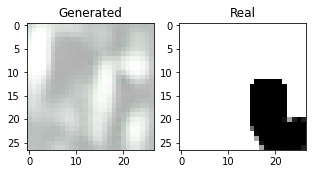

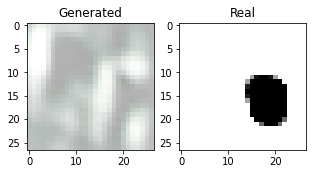

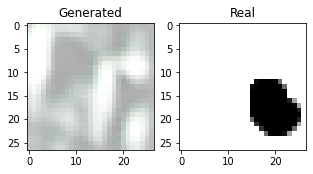

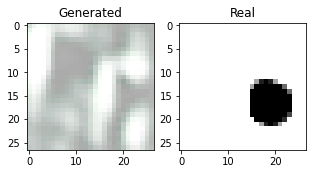

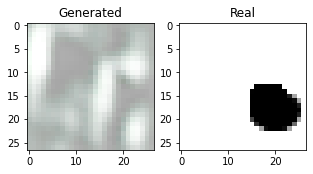

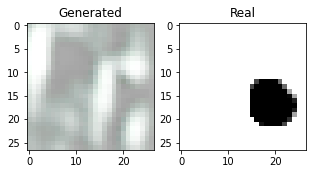

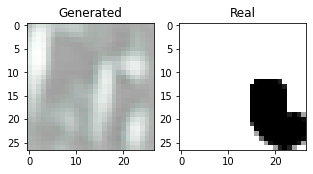

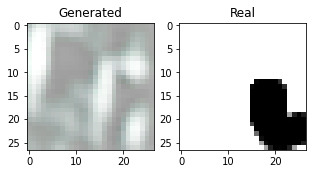

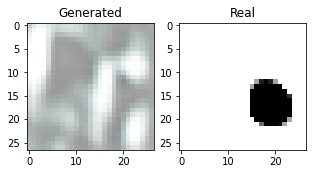

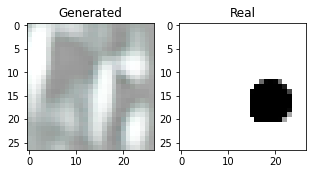

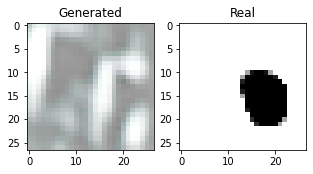

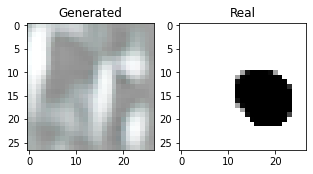

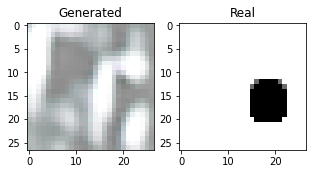

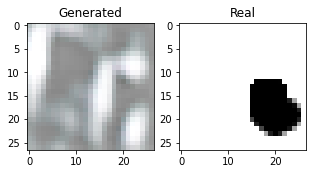

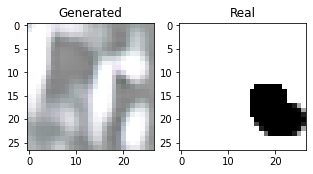

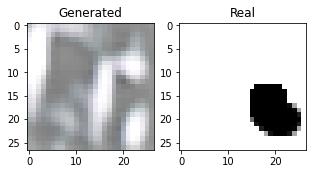

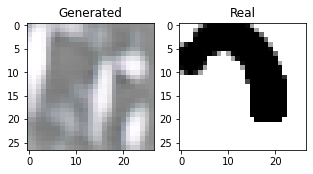

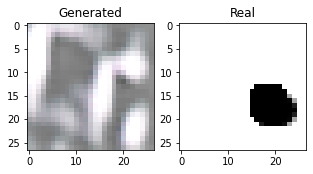

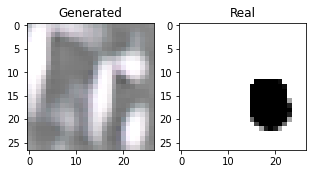

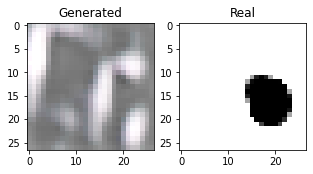

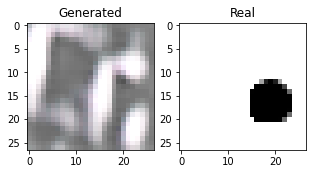

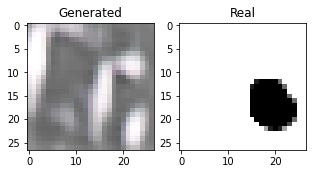

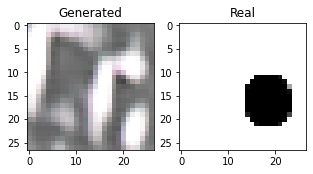

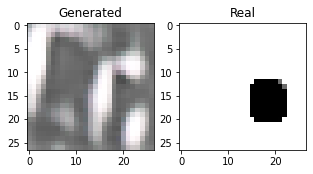

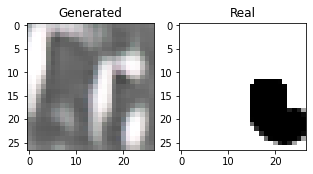

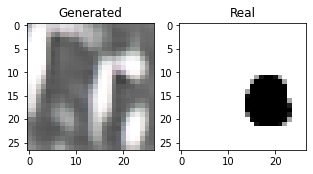

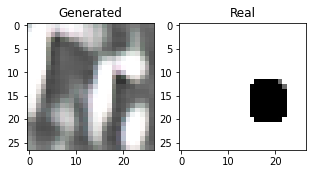

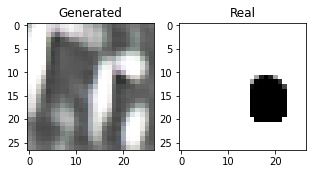

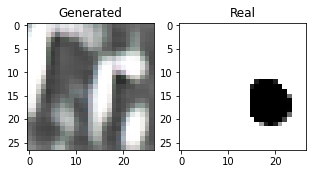

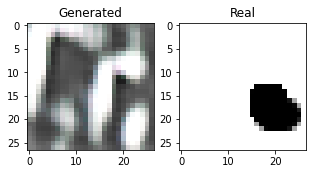

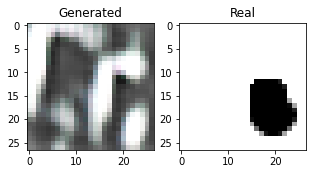

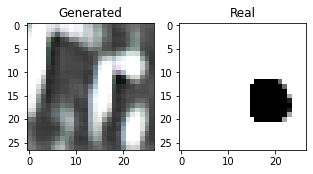

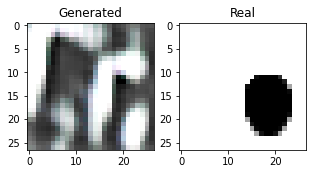

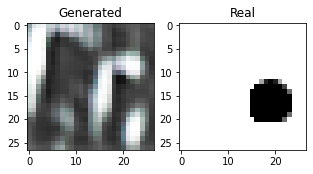

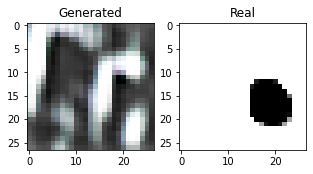

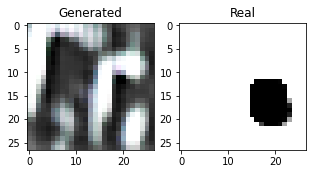

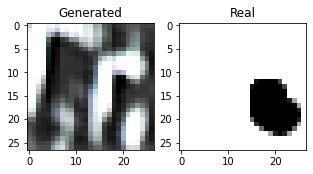

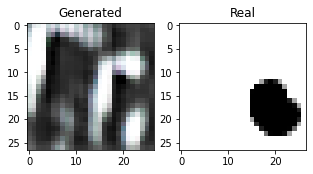

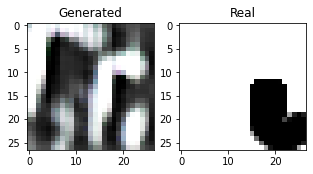

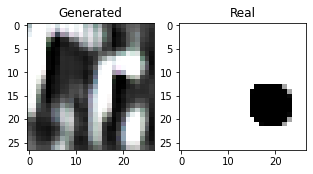

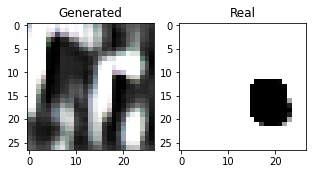

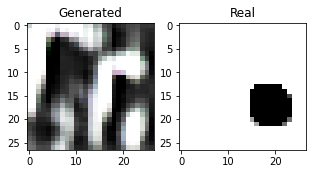

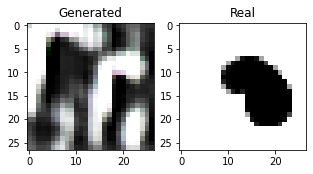

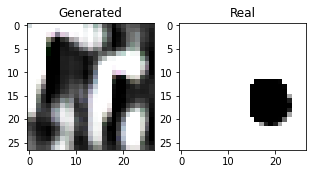

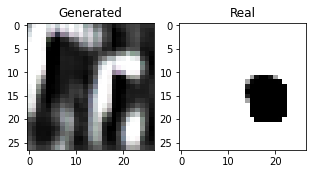

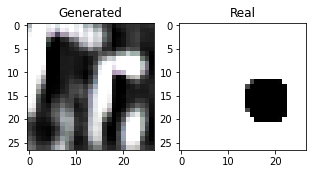

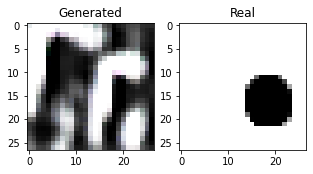

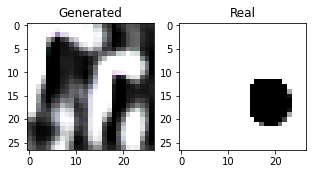

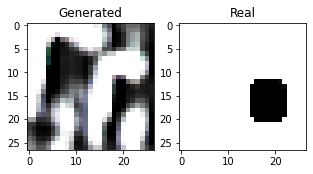

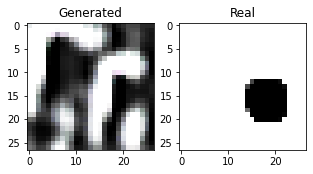

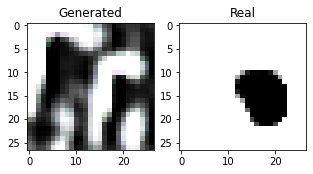

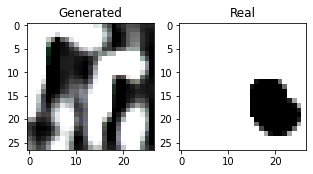

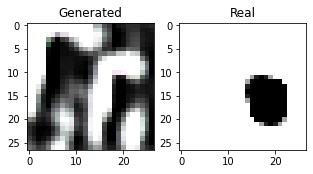

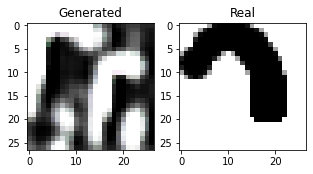

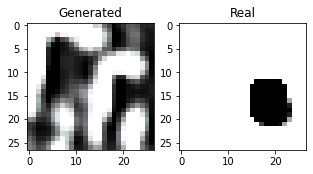

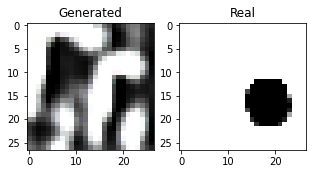

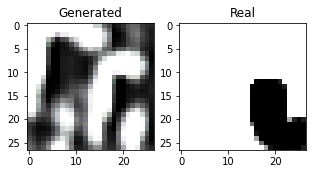

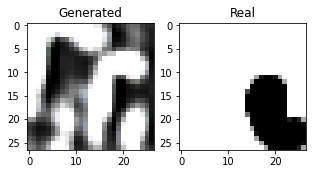

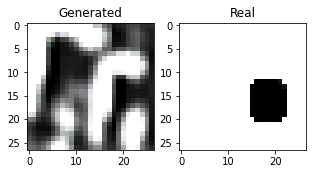

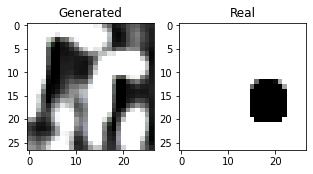

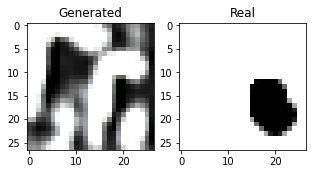

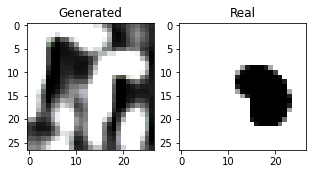

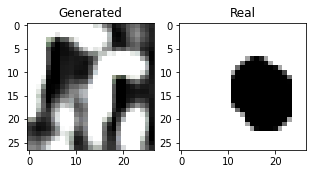

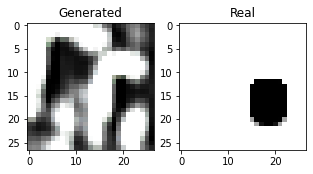

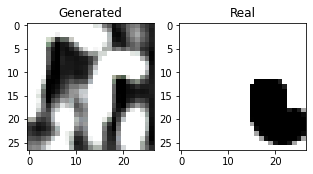

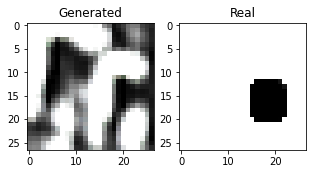

In [13]:
def reset_grad():
    generator.zero_grad()
    discriminator.zero_grad()

for epoch in range(config['epochs_num']):
    for _ in range(config['disc_coef']):  # TODO: (@whiteRa2bit, 2020-08-30) Replace with kwargs param
        # Sample data
        X = Variable(next(dataloader))
        X = X.to(config['device'])
        z = Variable(torch.rand(config['batch_size'], config['z_dim']))
        z = z.to(config['device'])

        # Dicriminator forward-loss-backward-update
        G_sample = generator(z)
        D_real = discriminator(X)
        D_fake = discriminator(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_optimizer.step()

        # # Weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)  # TODO: (@whiteRa2bit, 2020-08-30) Replace with kwargs param

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    X = Variable(next(dataloader))
    X = X.to(config['device'])
    z = Variable(torch.rand(config['batch_size'], config['z_dim']))
    z = z.to(config['device'])

    G_sample = generator(z)
    D_fake = discriminator(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_optimizer.step()

    # Housekeeping - reset gradient
    reset_grad()

    if epoch % config['log_each'] == 0:
        wandb.log({"D loss": D_loss.cpu().data, "G loss": G_loss.cpu().data.numpy()})

        generated_sample = G_sample[0].cpu().data
        generated_sample = np.array(generated_sample.permute(1, 2, 0))
        generated_sample[generated_sample > 1] = 1.0
        generated_sample[generated_sample < 0] = 0.0
        real_sample = X[0].cpu().data
        real_sample = np.array(real_sample.permute(1, 2, 0))
        
        f, ax = plt.subplots(1, 2, figsize=(5, 12))
        ax[0].set_title("Generated")
        ax[0].imshow(generated_sample)
        ax[1].set_title("Real")
        ax[1].imshow(real_sample)
        plt.show()

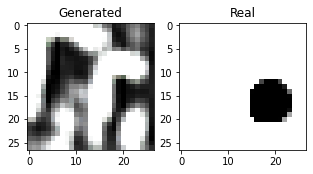

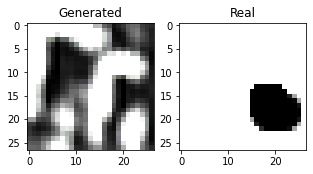

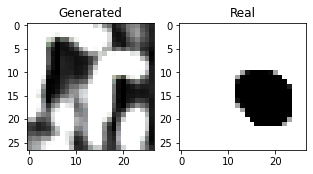

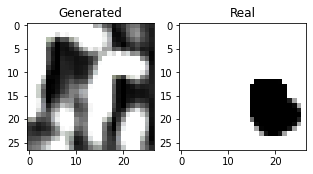

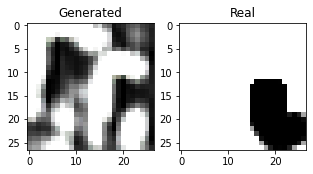

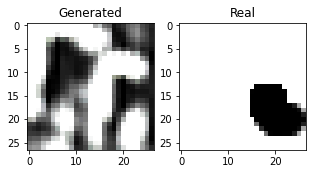

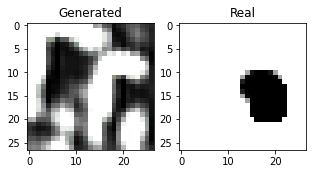

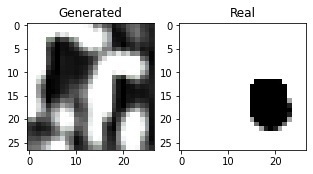

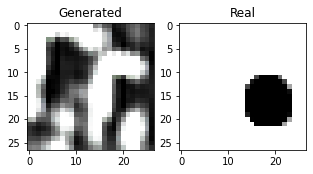

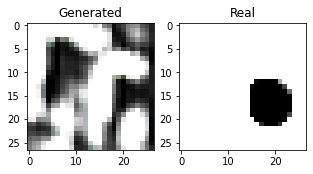

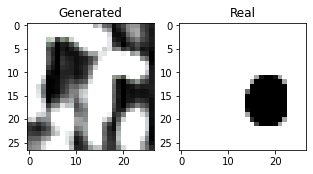

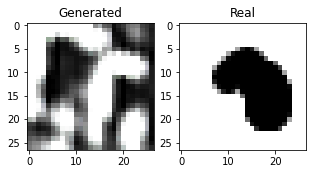

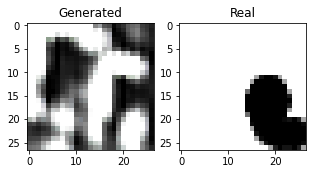

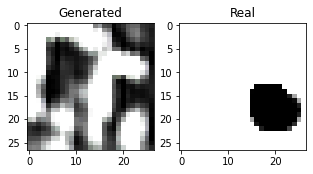

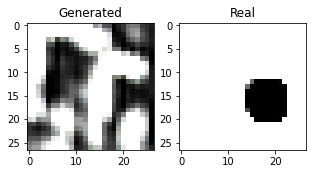

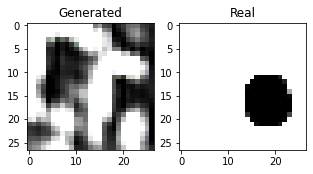

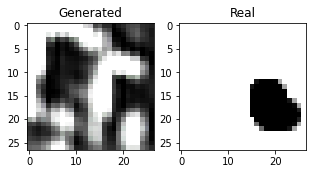

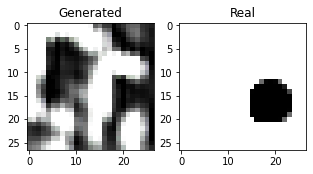

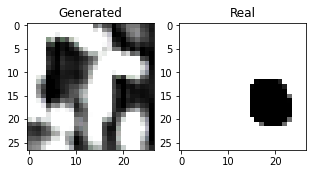

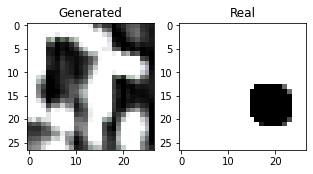

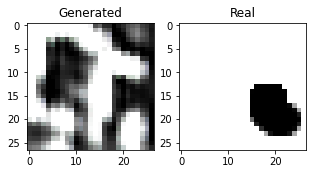

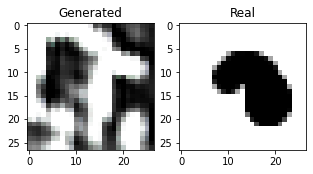

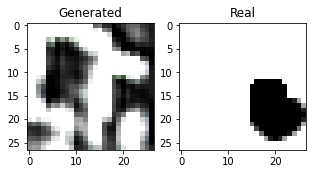

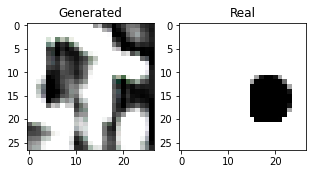

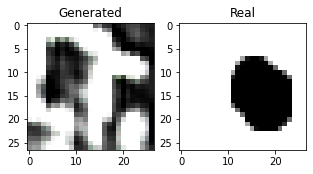

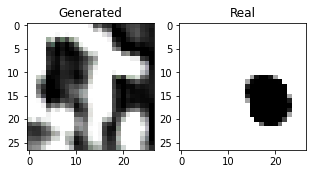

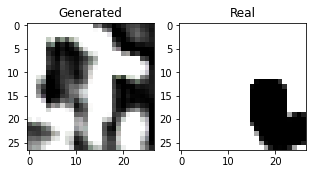

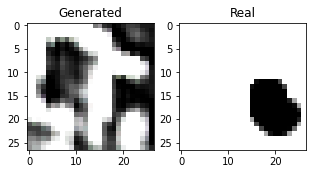

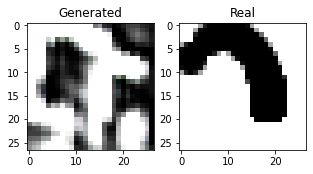

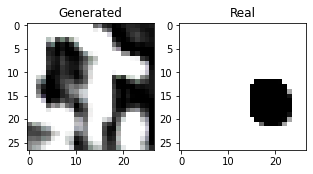

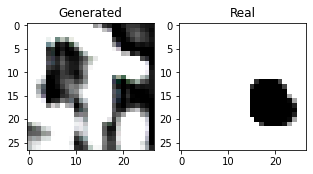

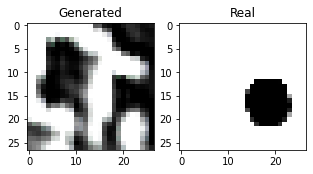

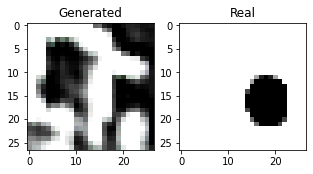

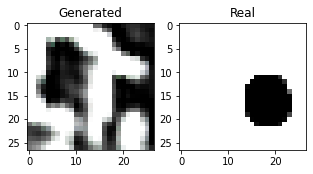

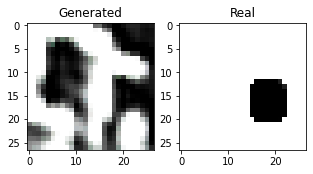

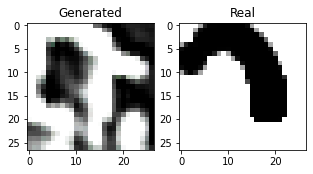

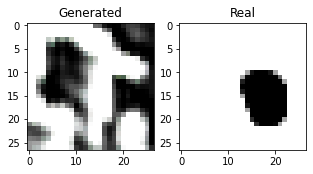

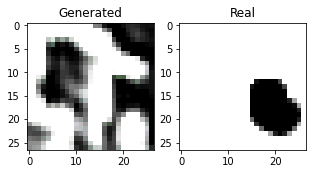

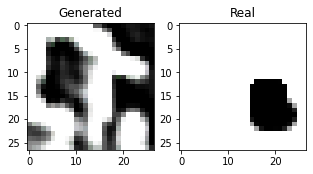

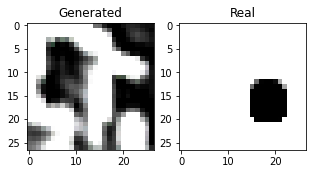

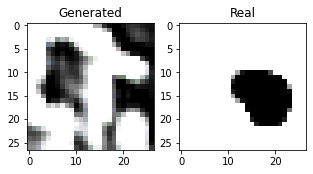

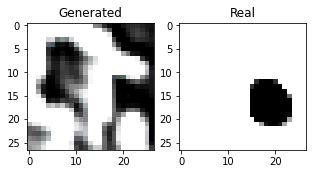

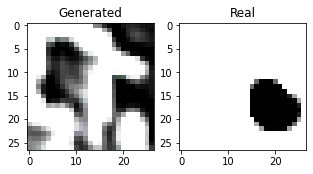

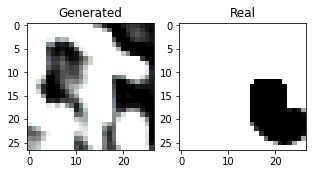

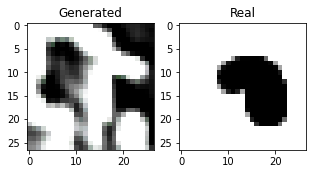

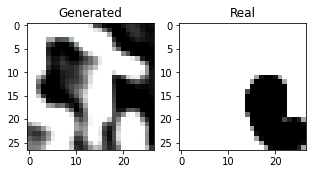

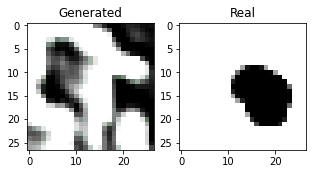

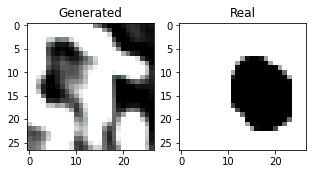

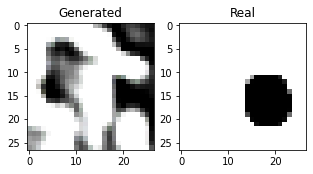

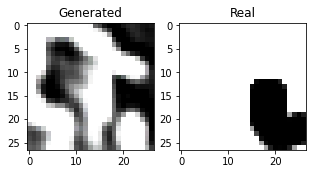

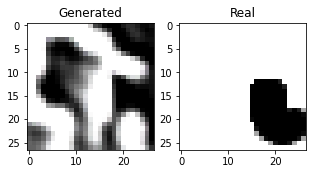

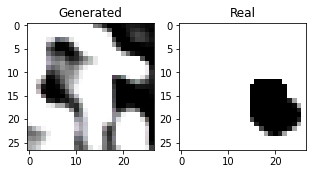

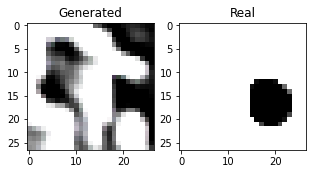

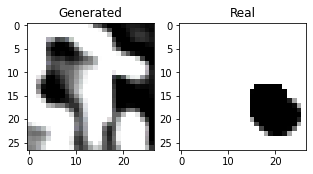

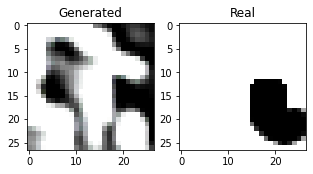

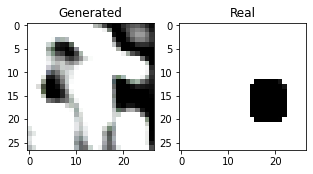

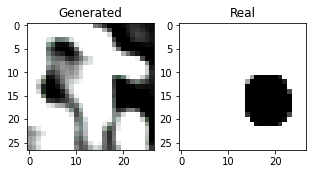

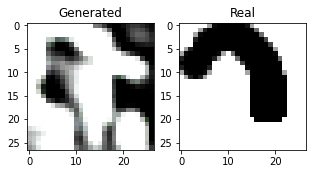

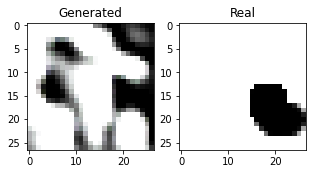

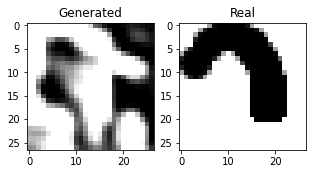

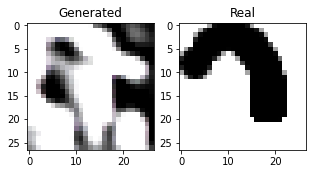

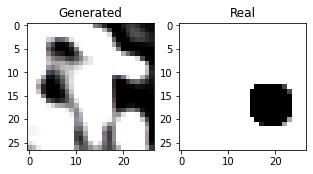

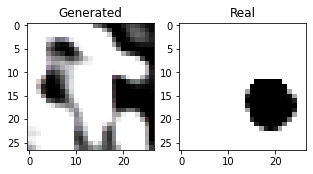

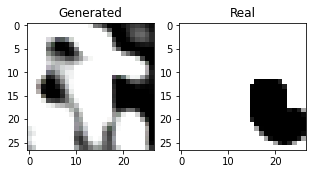

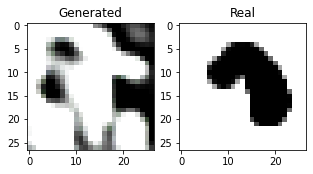

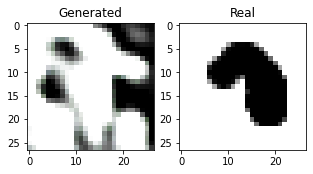

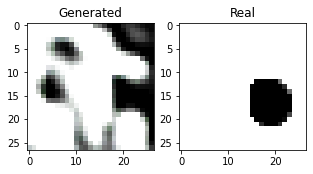

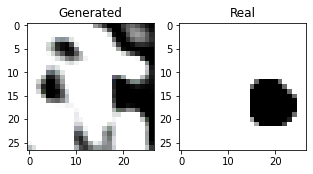

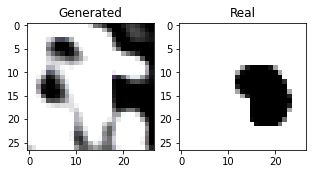

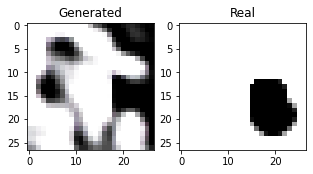

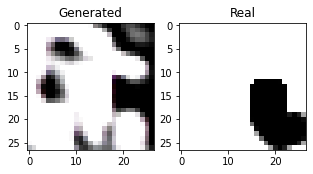

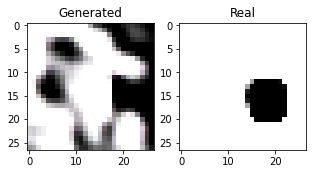

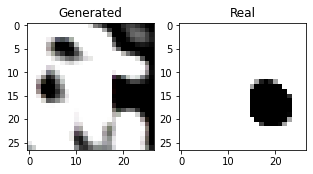

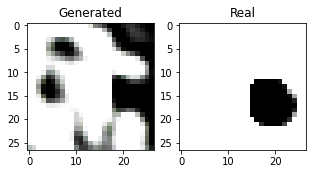

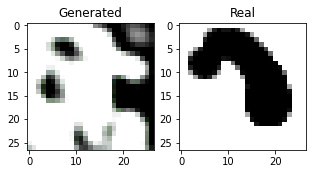

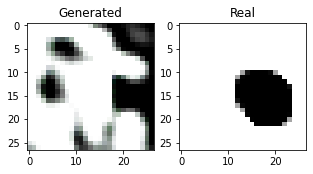

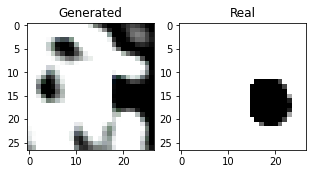

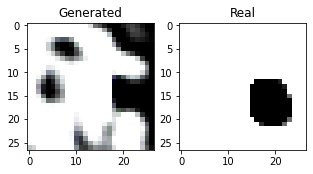

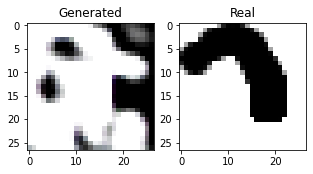

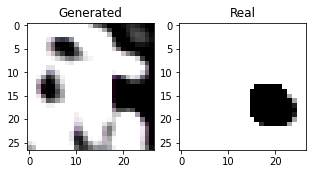

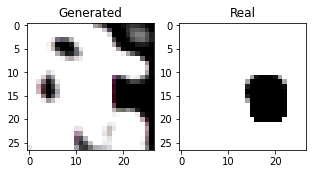

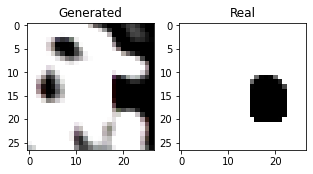

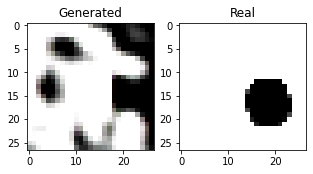

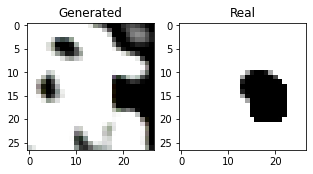

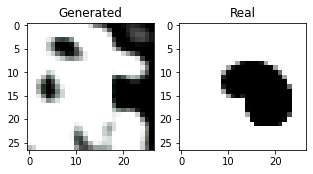

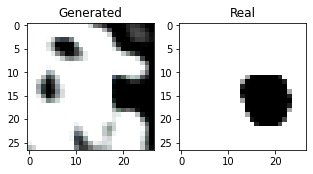

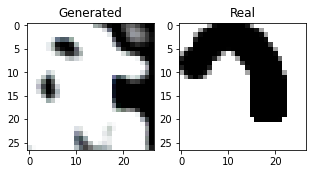

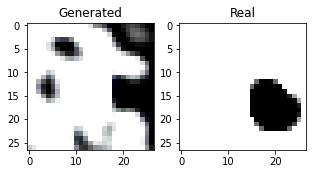

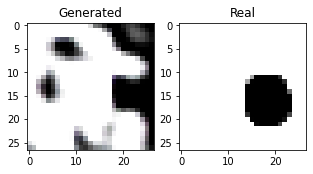

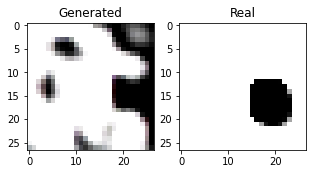

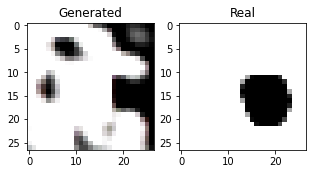

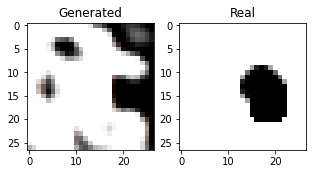

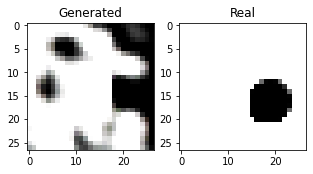

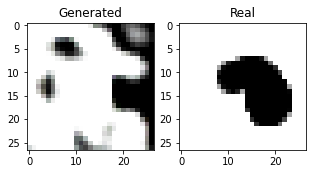

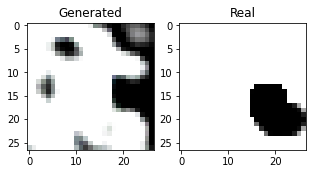

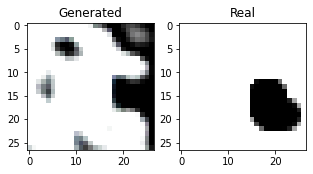

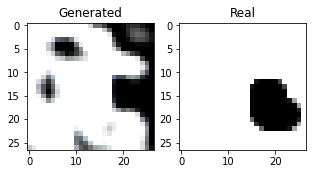

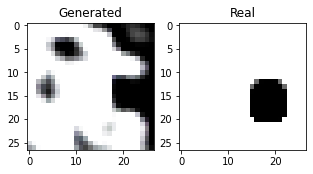

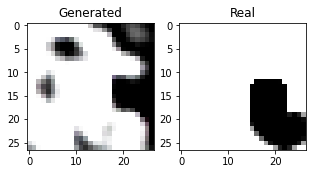

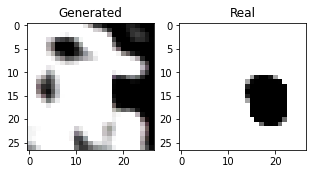

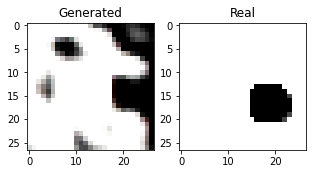

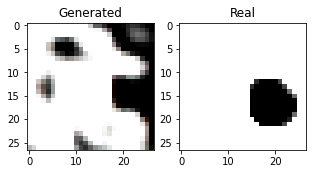

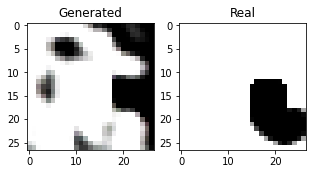

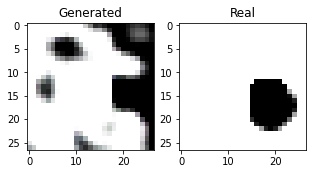

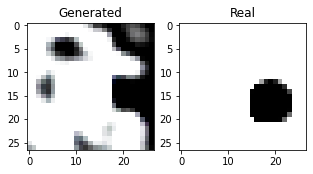

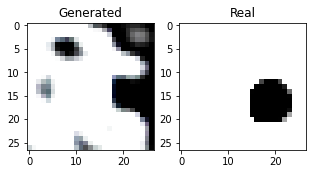

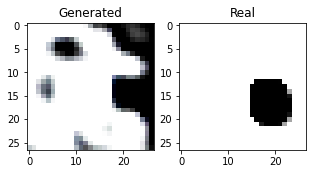

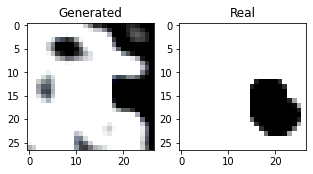

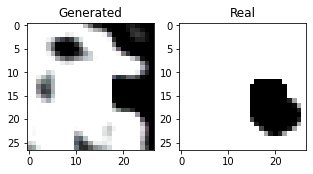

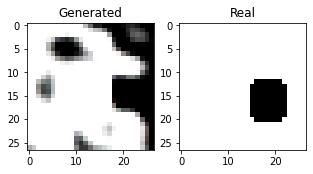

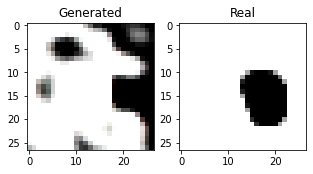

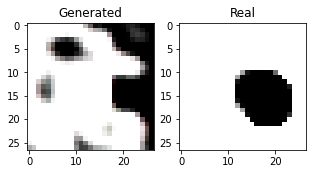

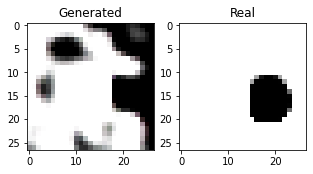

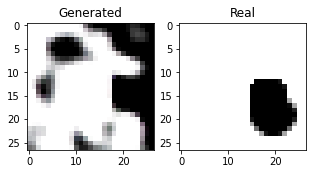

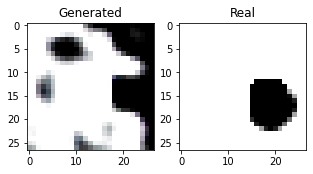

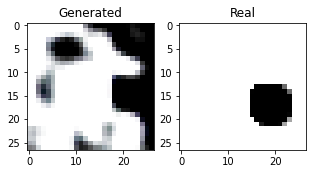

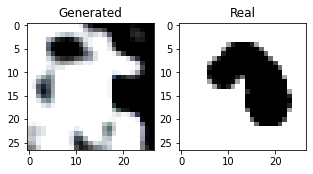

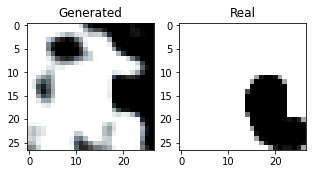

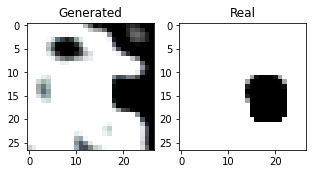

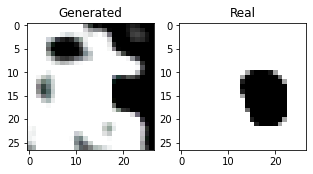

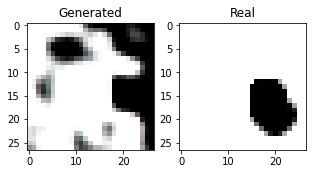

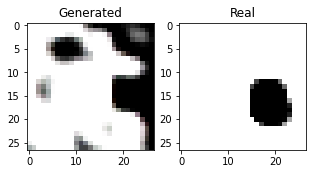

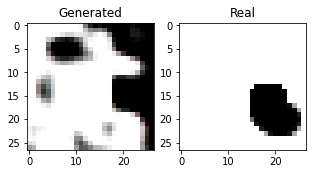

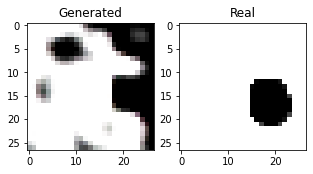

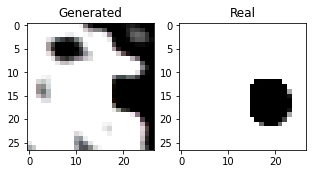

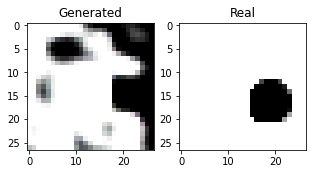

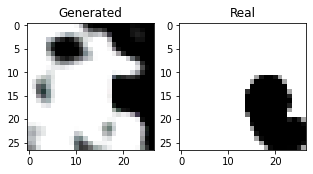

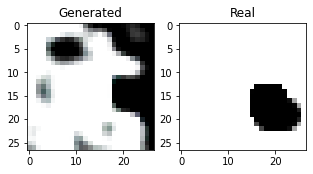

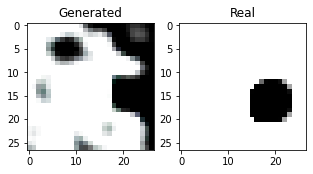

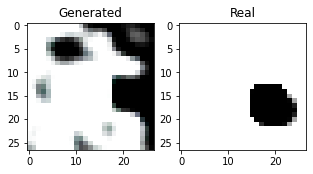

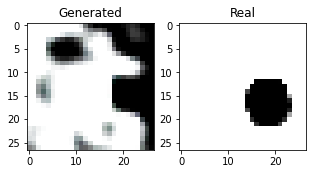

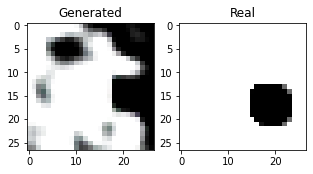

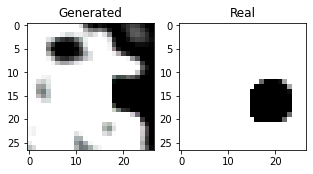

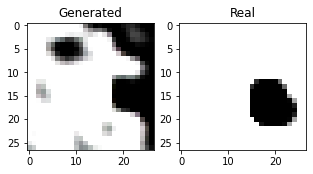

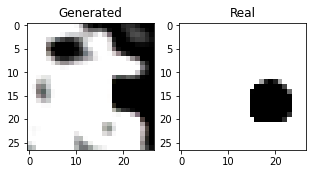

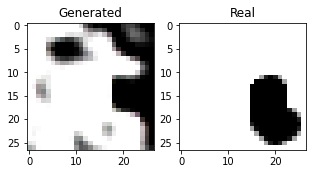

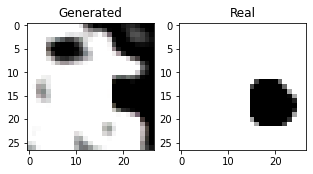

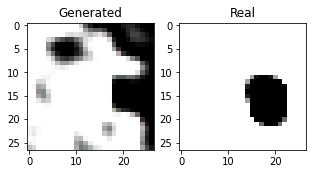

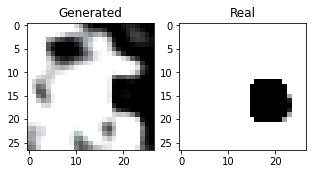

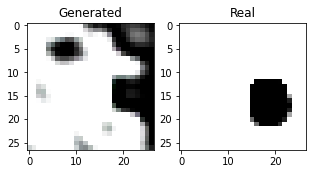

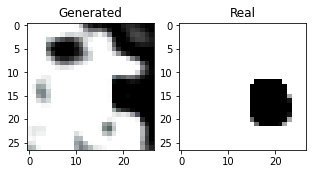

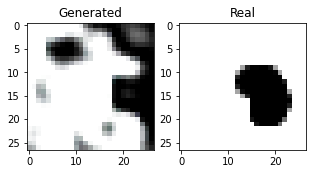

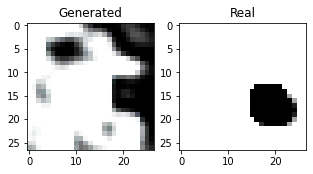

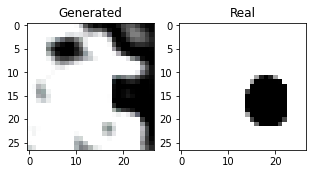

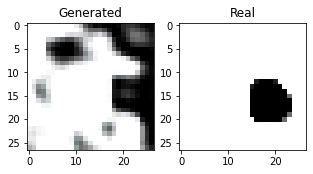

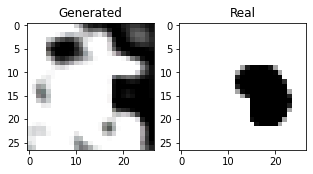

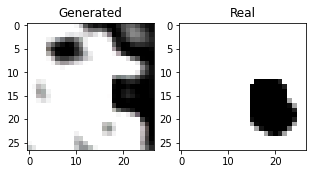

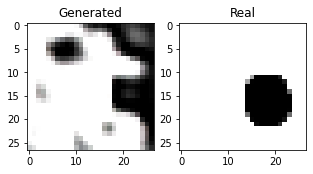

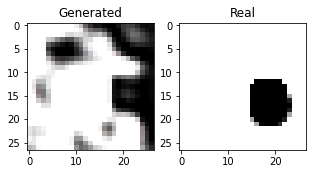

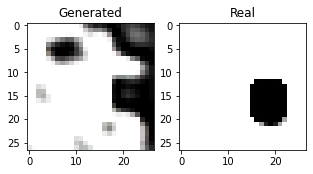

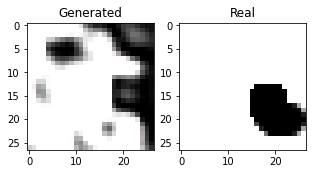

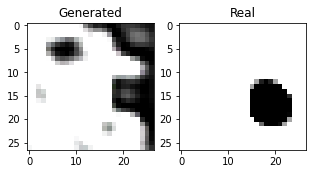

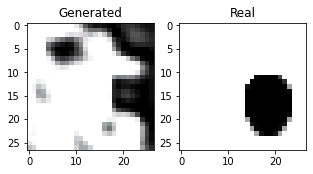

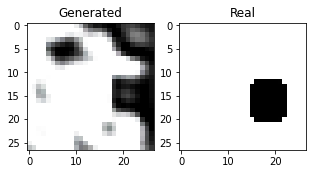

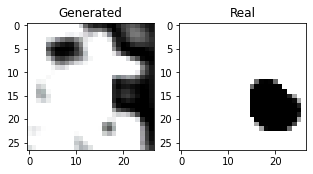

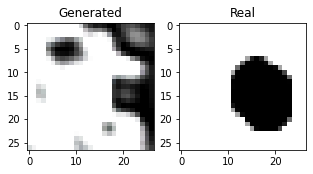

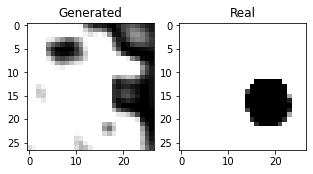

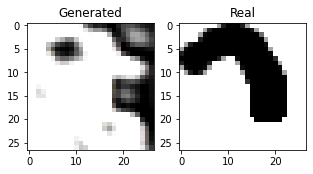

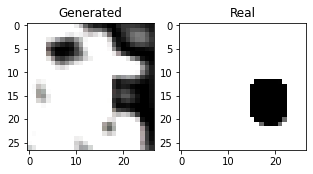

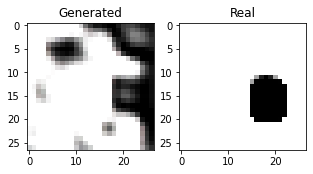

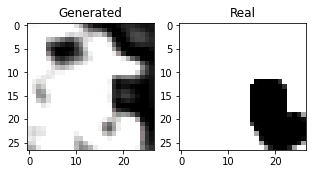

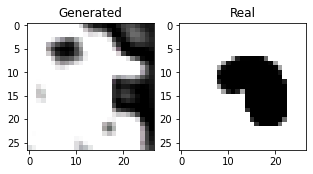

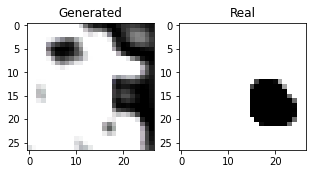

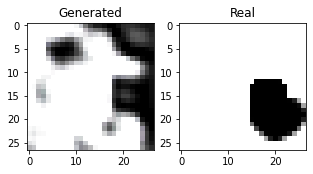

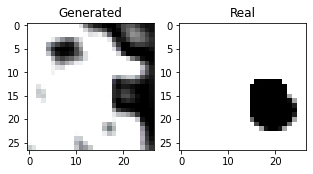

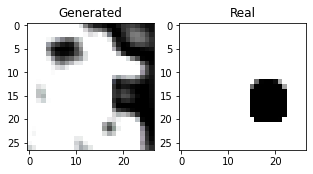

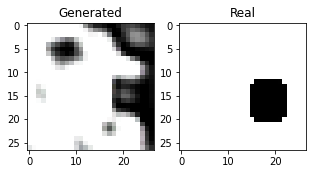

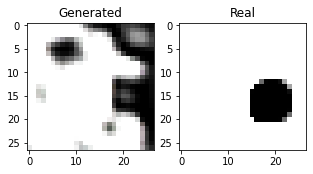

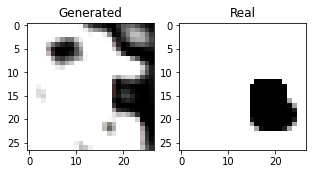

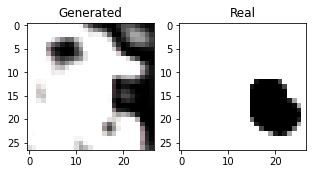

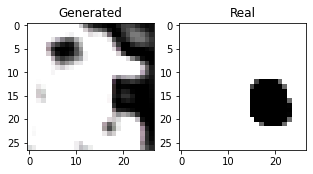

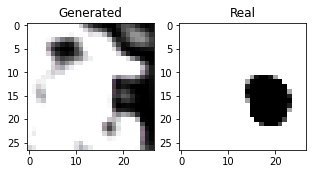

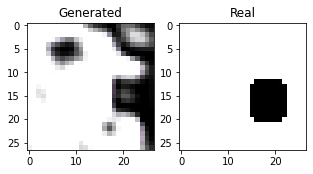

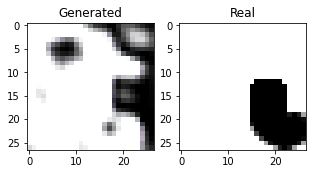

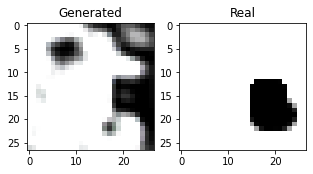

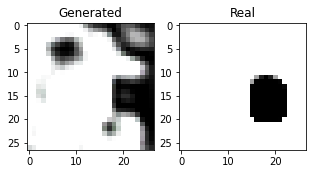

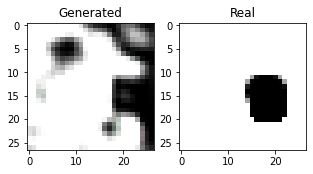

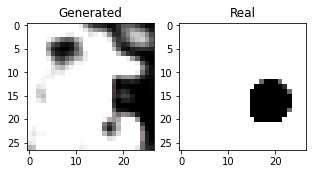

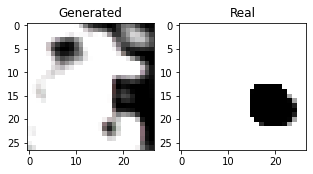

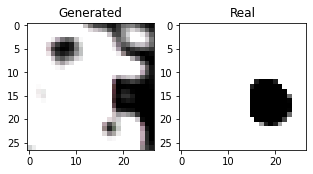

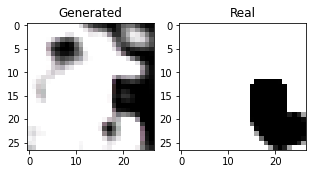

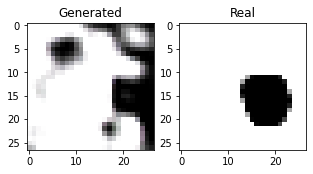

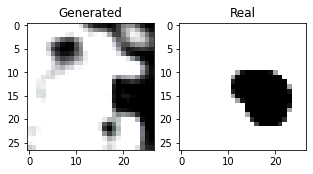

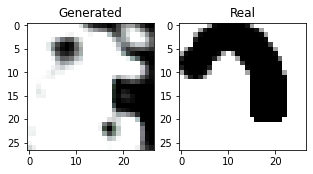

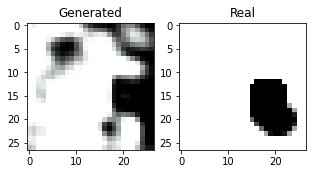

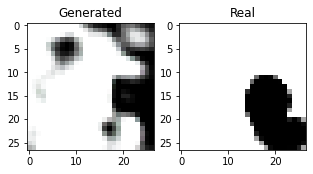

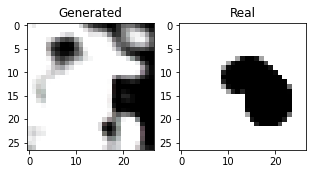

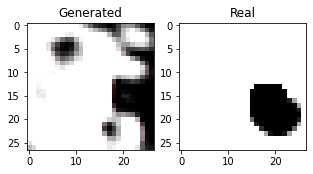

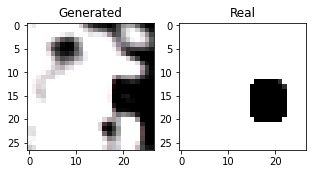

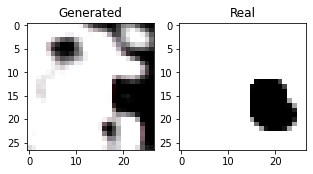

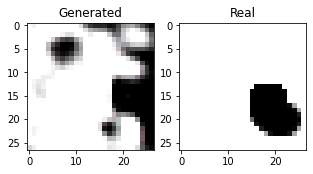

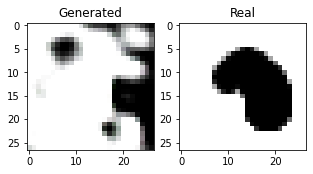

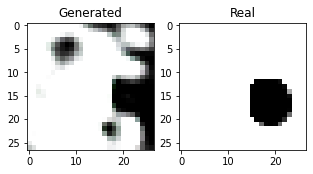

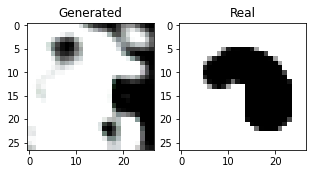

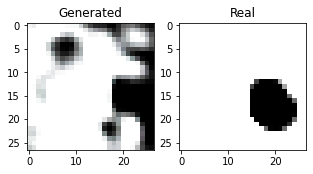

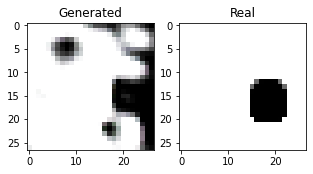

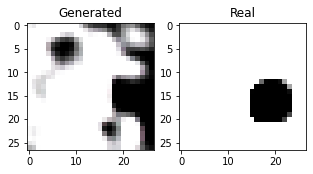

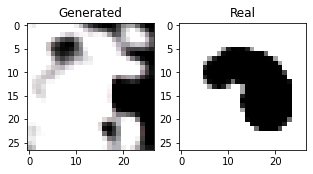

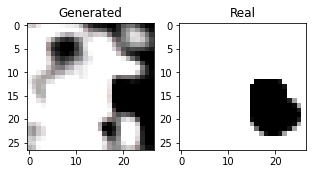

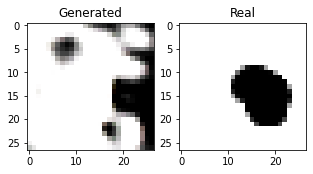

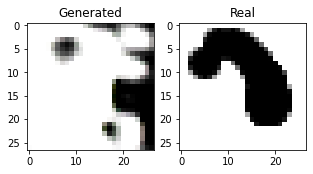

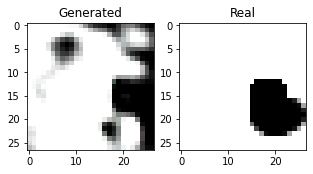

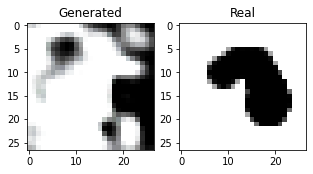

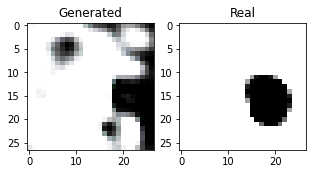

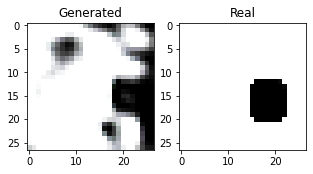

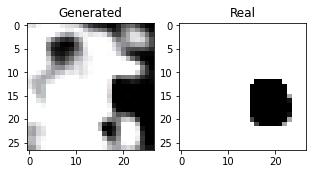

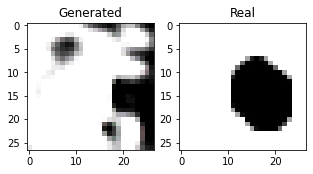

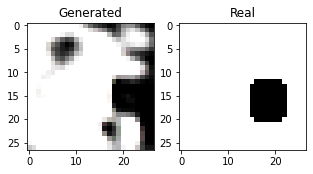

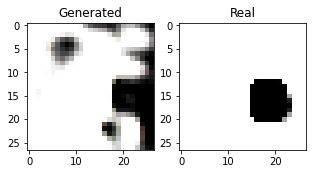

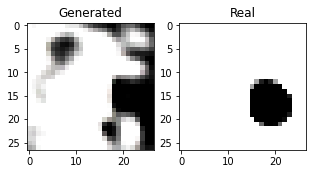

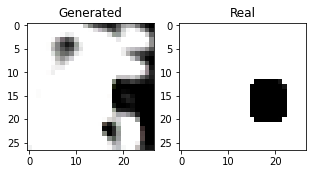

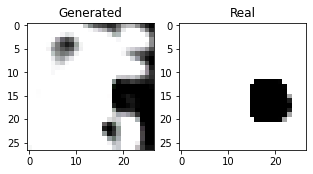

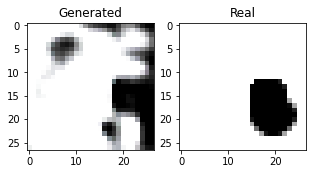

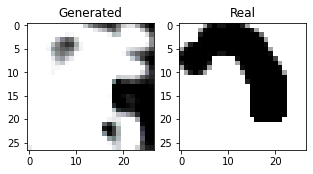

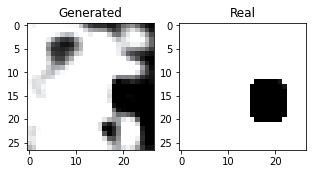

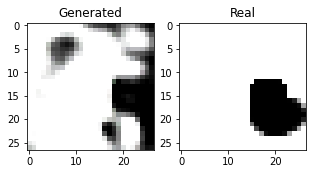

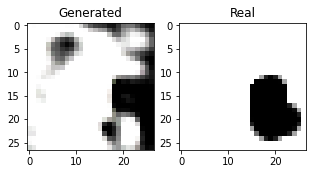

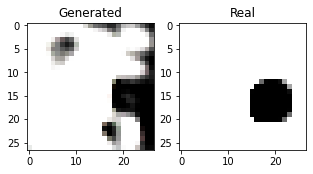

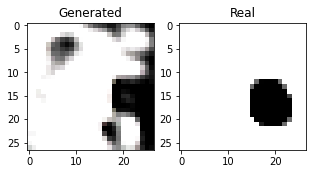

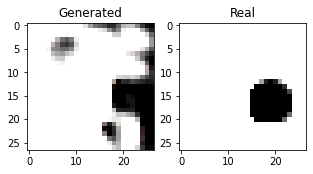

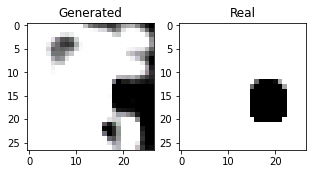

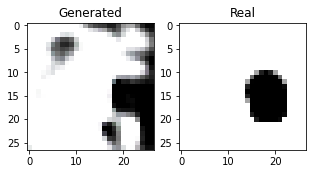

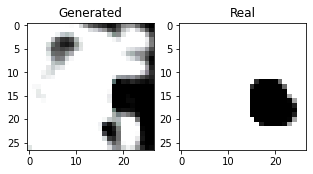

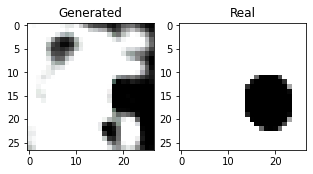

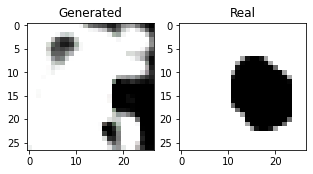

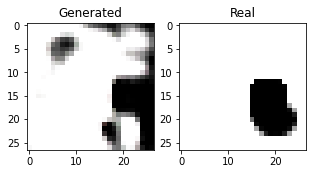

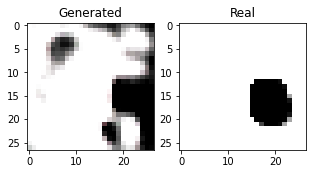

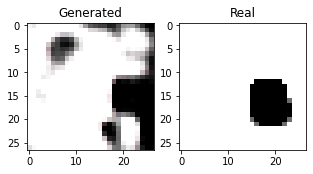

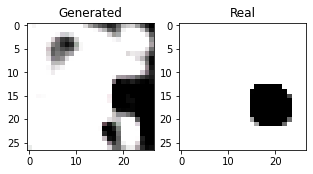

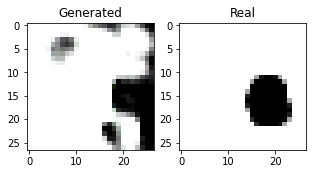

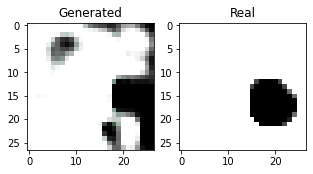

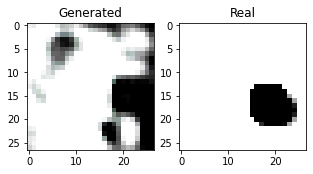

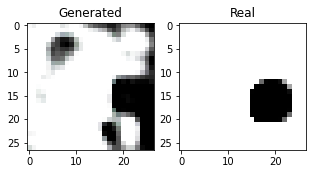

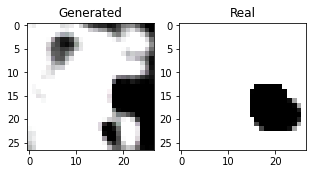

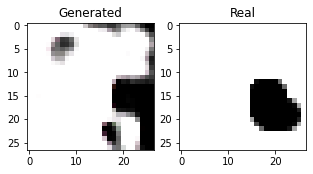

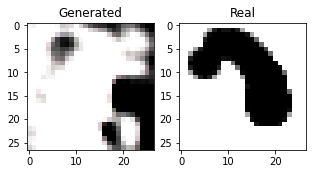

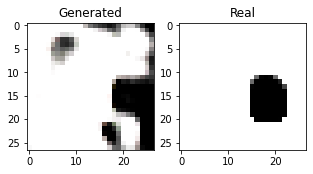

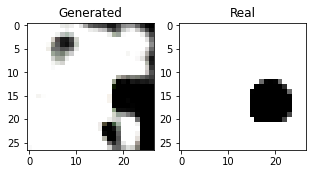

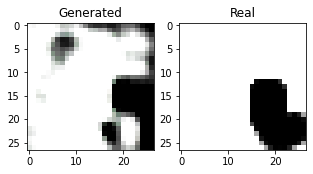

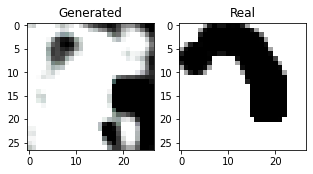

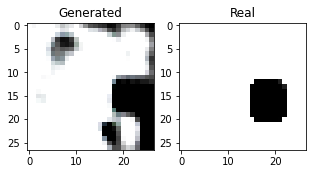

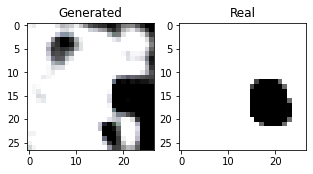

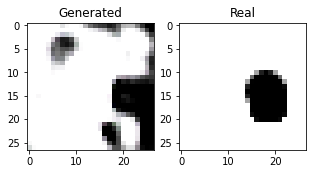

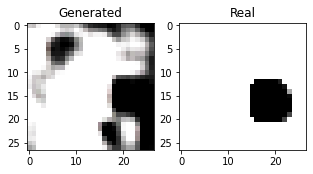

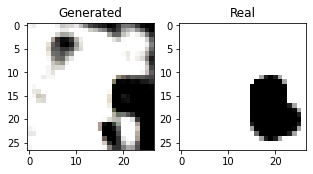

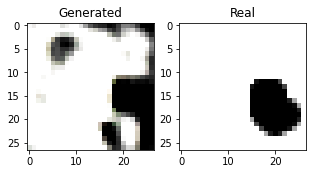

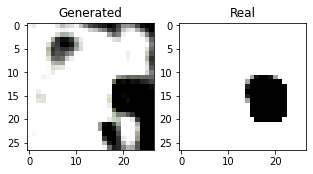

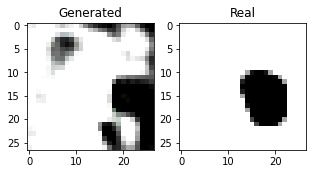

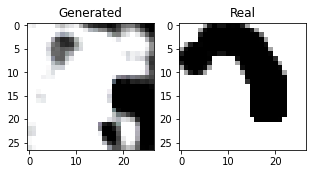

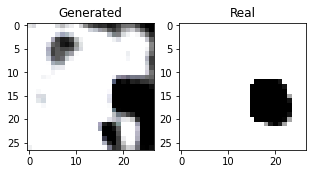

In [14]:
def reset_grad():
    generator.zero_grad()
    discriminator.zero_grad()

for epoch in range(config['epochs_num']):
    for _ in range(config['disc_coef']):  # TODO: (@whiteRa2bit, 2020-08-30) Replace with kwargs param
        # Sample data
        X = Variable(next(dataloader))
        X = X.to(config['device'])
        z = Variable(torch.rand(config['batch_size'], config['z_dim']))
        z = z.to(config['device'])

        # Dicriminator forward-loss-backward-update
        G_sample = generator(z)
        D_real = discriminator(X)
        D_fake = discriminator(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_optimizer.step()

        # # Weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)  # TODO: (@whiteRa2bit, 2020-08-30) Replace with kwargs param

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    X = Variable(next(dataloader))
    X = X.to(config['device'])
    z = Variable(torch.rand(config['batch_size'], config['z_dim']))
    z = z.to(config['device'])

    G_sample = generator(z)
    D_fake = discriminator(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_optimizer.step()

    # Housekeeping - reset gradient
    reset_grad()

    if epoch % config['log_each'] == 0:
        wandb.log({"D loss": D_loss.cpu().data, "G loss": G_loss.cpu().data.numpy()})

        generated_sample = G_sample[0].cpu().data
        generated_sample = np.array(generated_sample.permute(1, 2, 0))
        generated_sample[generated_sample > 1] = 1.0
        generated_sample[generated_sample < 0] = 0.0
        real_sample = X[0].cpu().data
        real_sample = np.array(real_sample.permute(1, 2, 0))
        
        f, ax = plt.subplots(1, 2, figsize=(5, 12))
        ax[0].set_title("Generated")
        ax[0].imshow(generated_sample)
        ax[1].set_title("Real")
        ax[1].imshow(real_sample)
        plt.show()

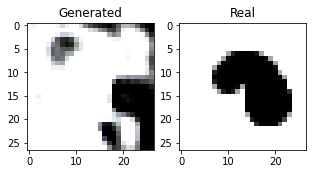

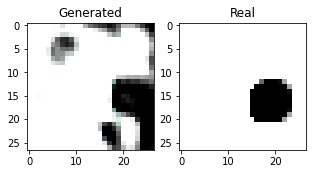

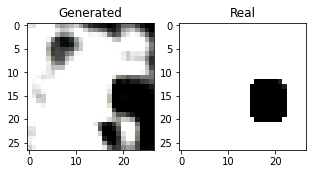

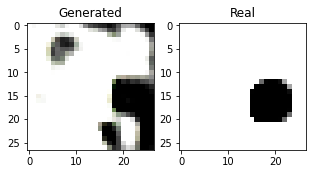

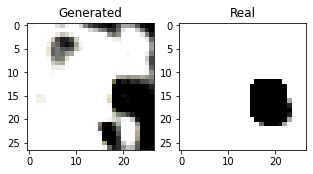

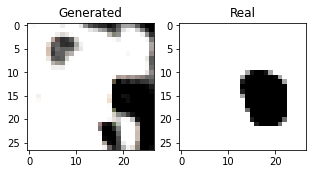

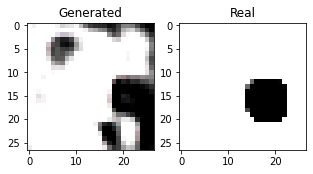

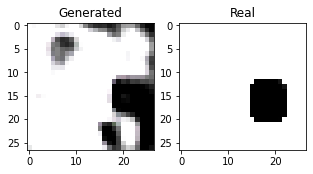

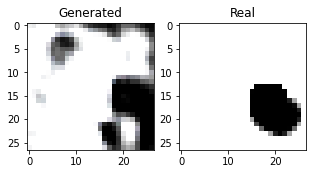

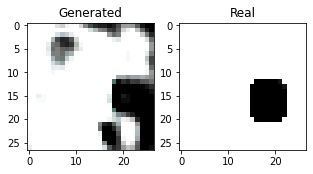

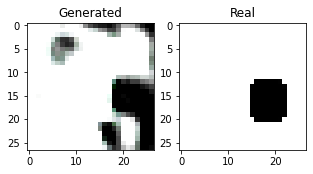

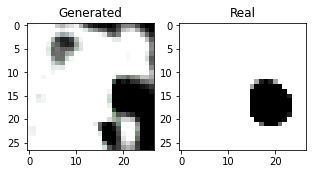

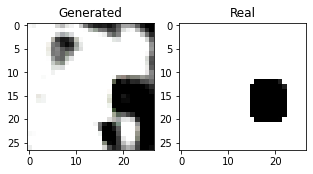

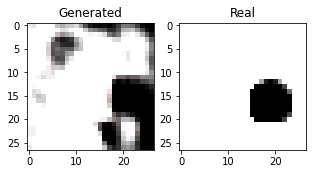

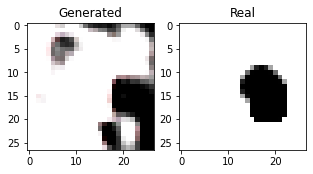

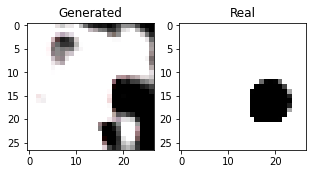

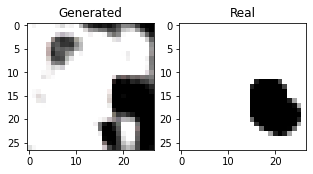

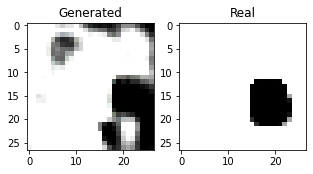

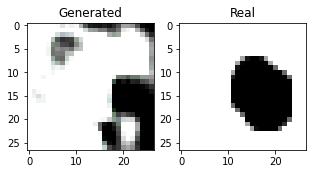

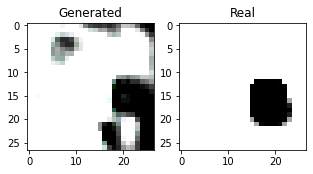

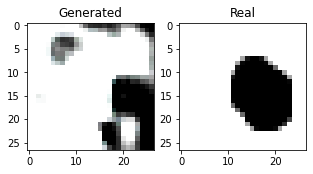

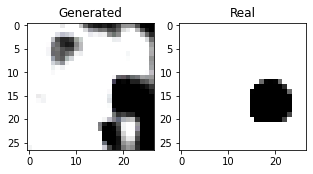

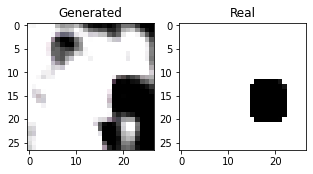

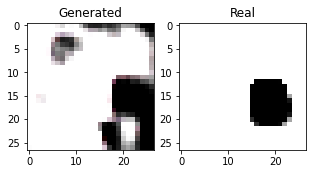

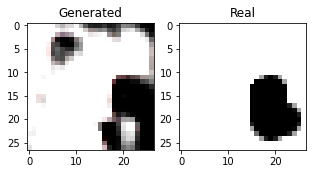

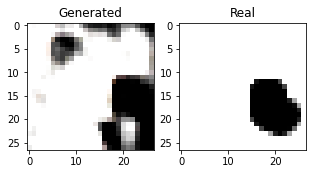

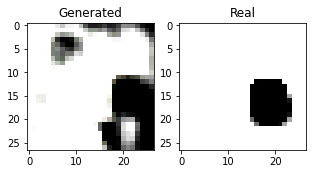

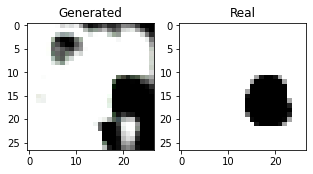

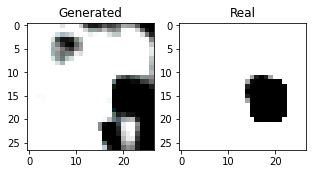

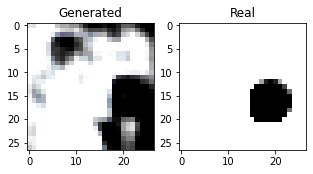

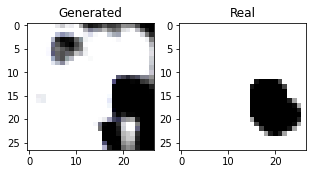

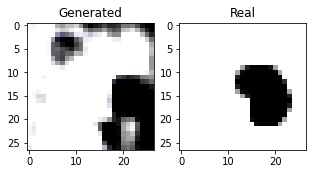

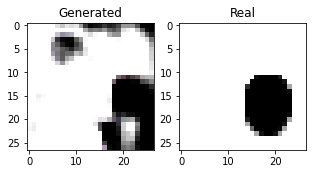

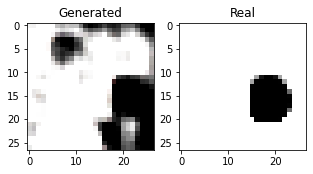

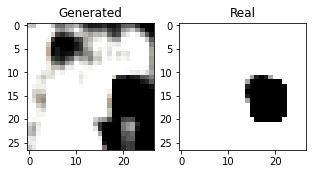

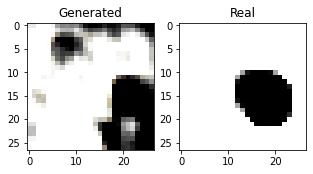

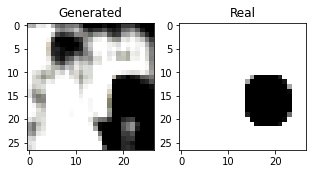

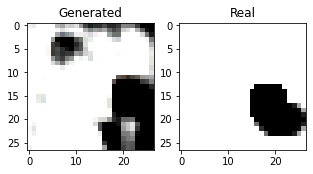

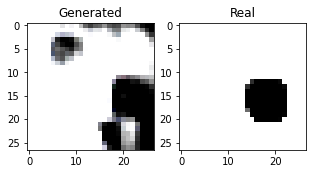

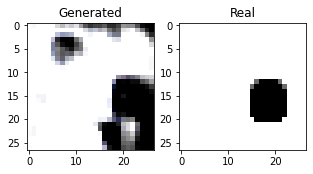

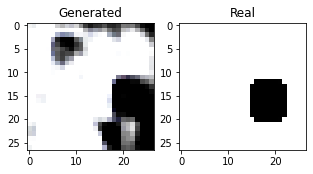

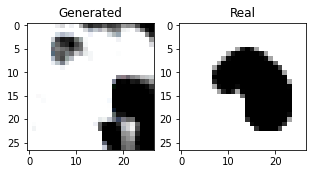

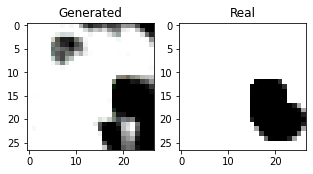

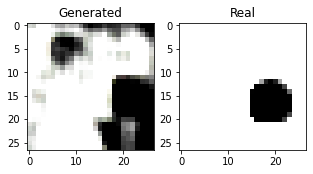

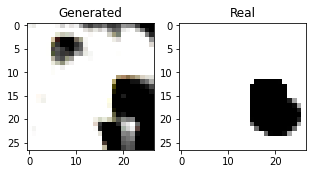

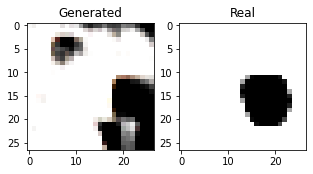

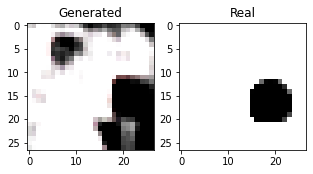

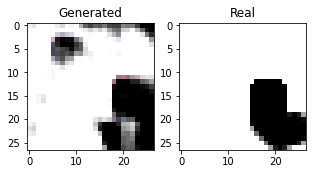

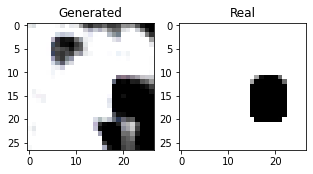

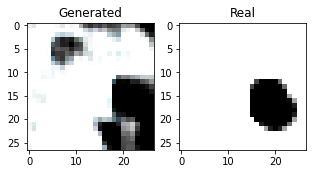

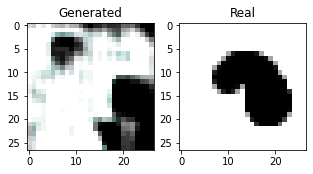

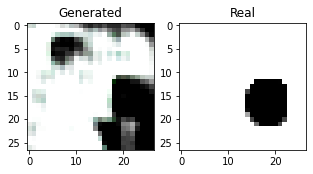

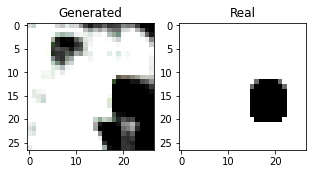

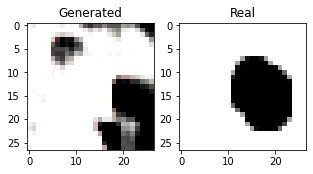

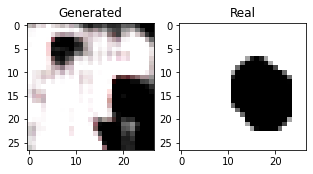

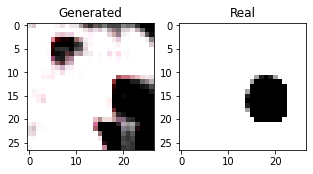

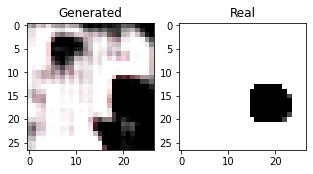

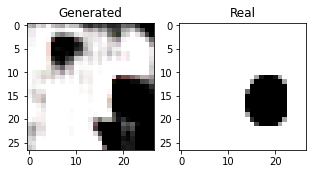

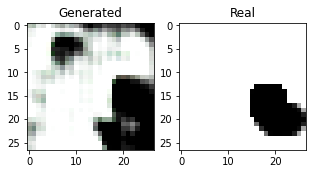

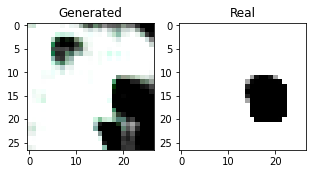

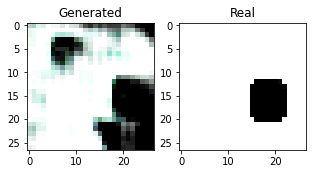

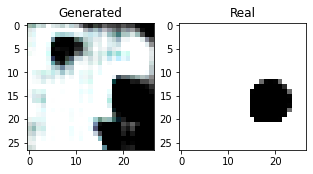

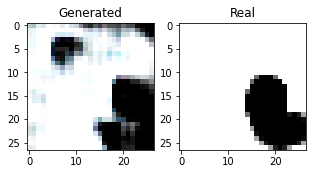

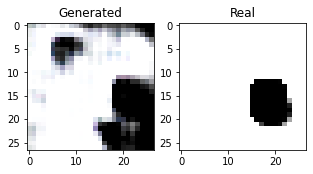

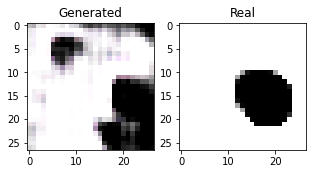

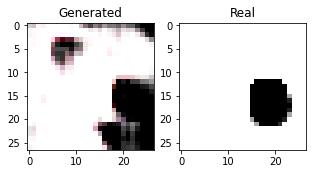

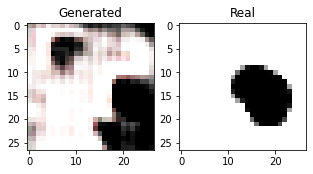

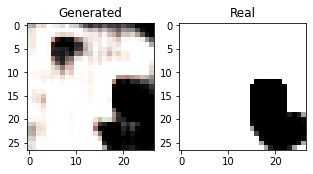

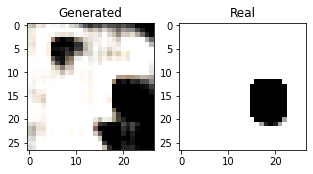

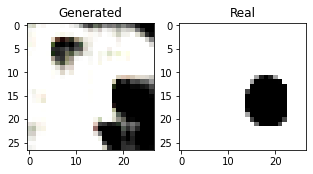

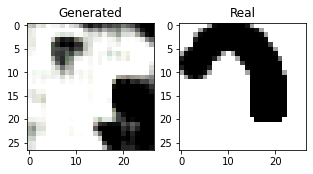

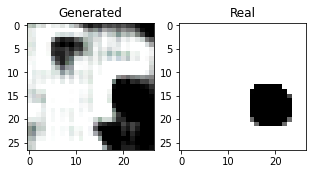

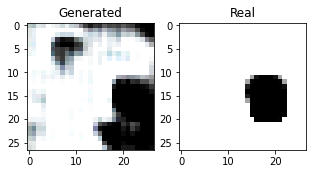

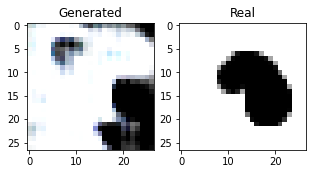

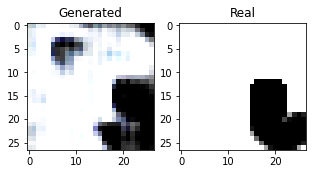

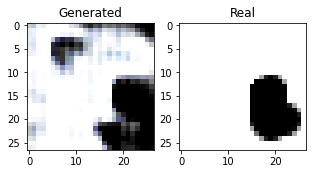

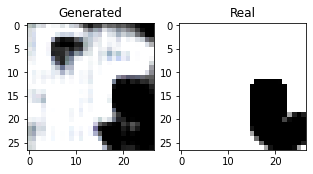

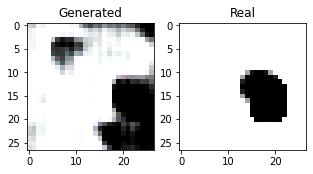

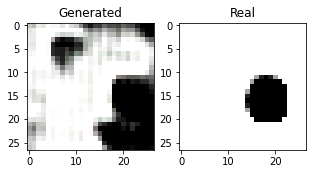

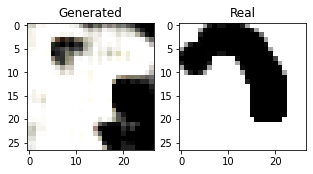

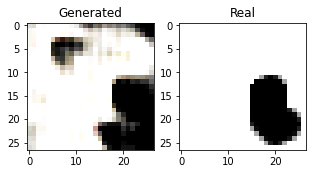

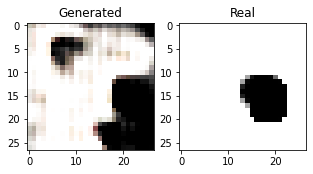

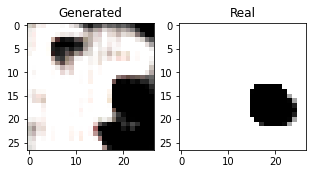

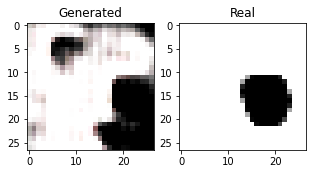

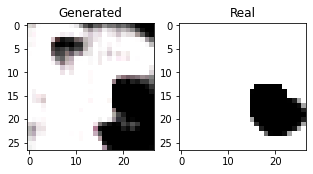

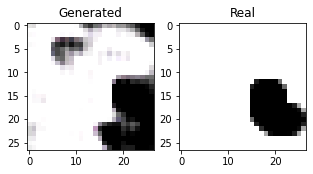

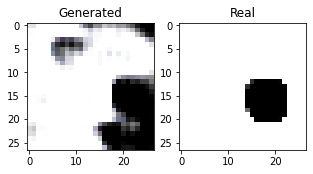

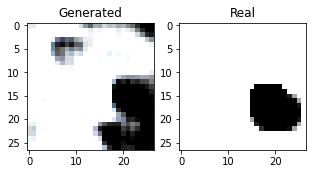

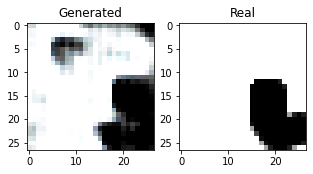

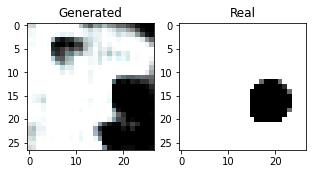

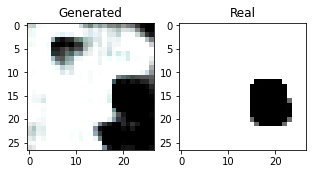

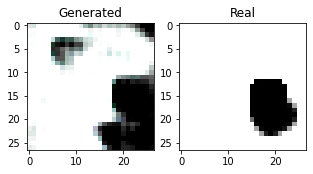

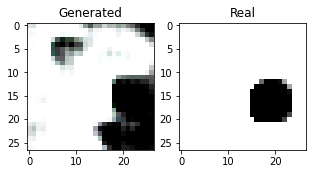

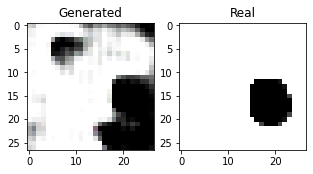

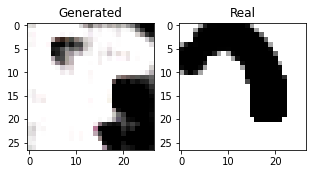

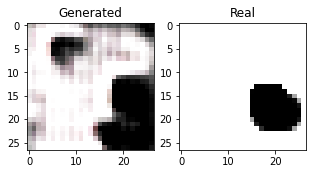

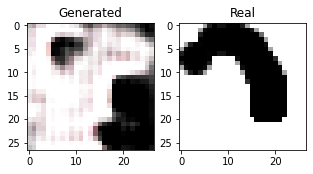

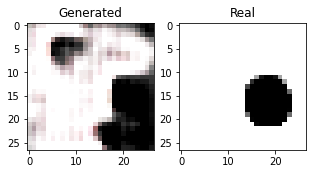

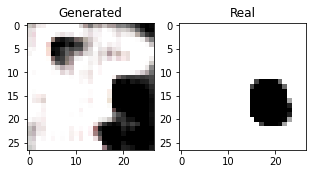

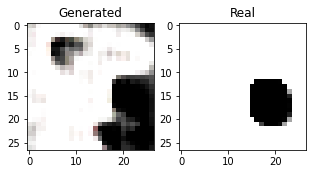

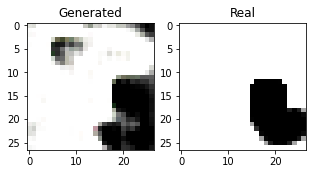

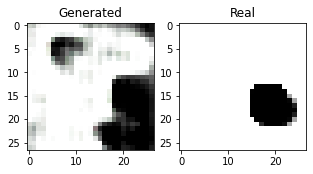

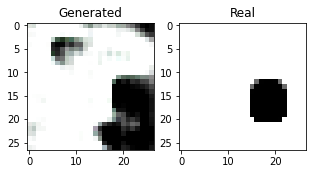

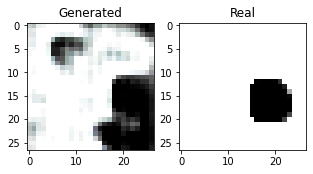

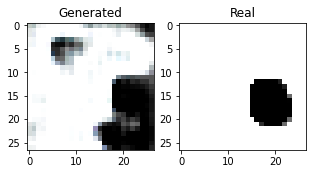

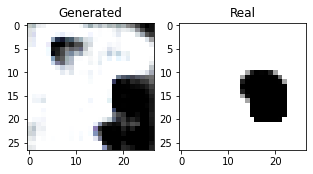

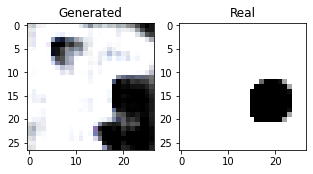

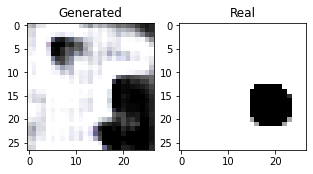

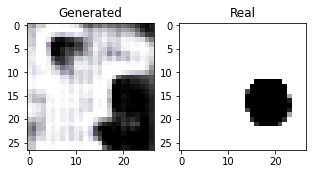

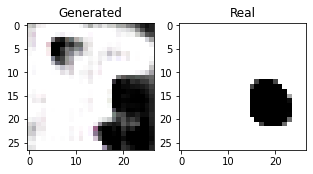

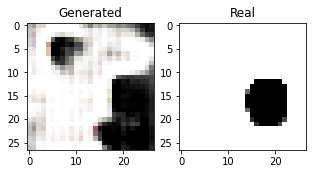

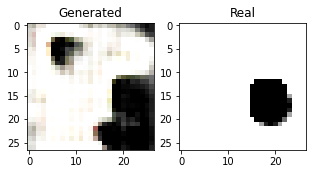

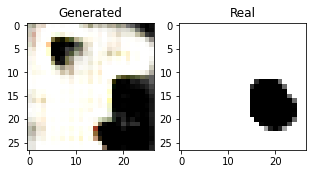

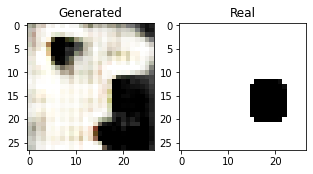

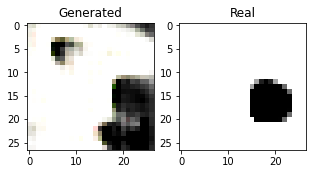

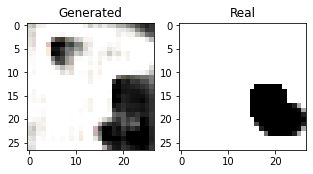

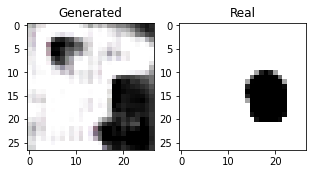

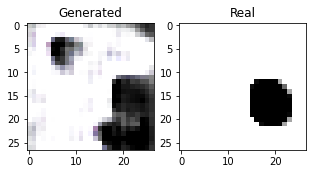

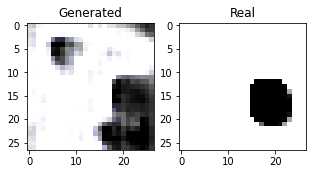

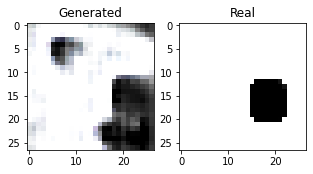

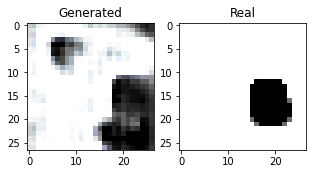

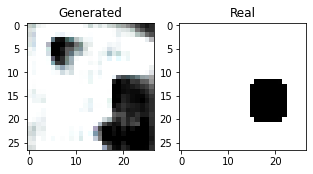

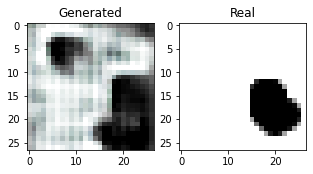

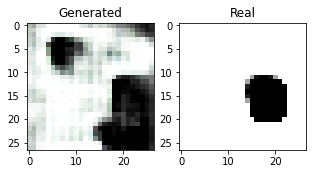

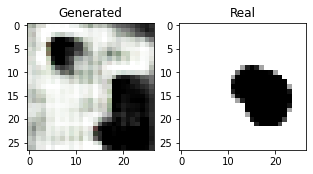

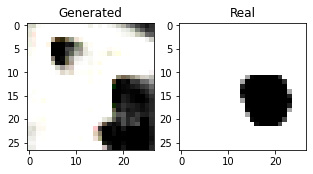

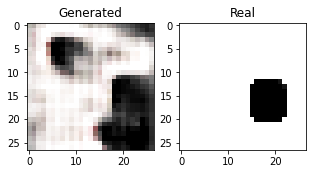

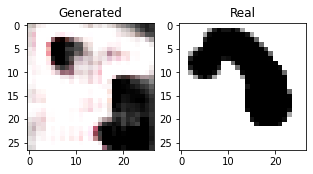

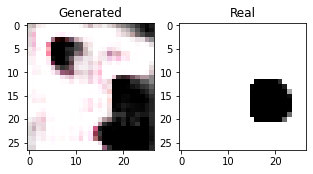

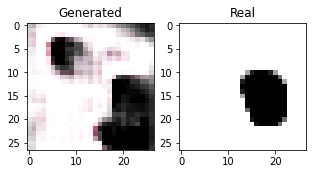

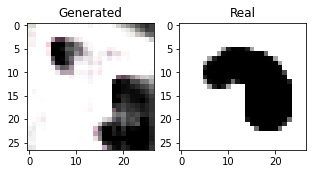

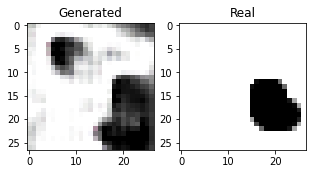

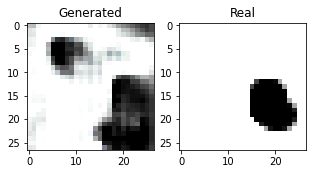

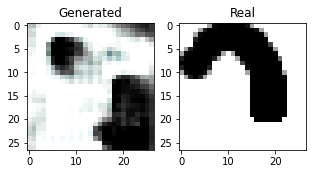

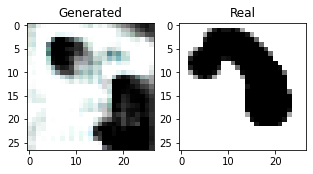

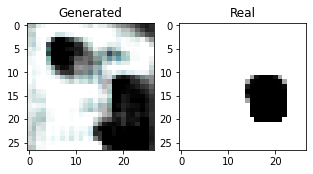

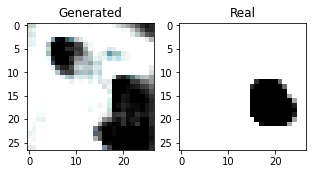

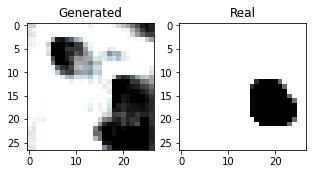

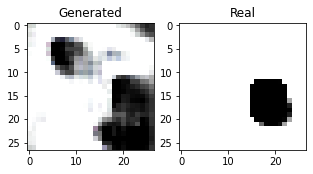

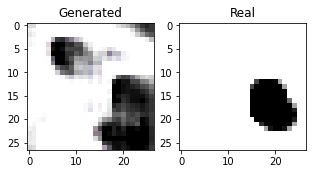

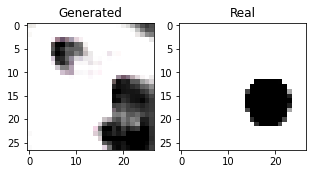

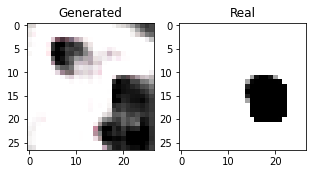

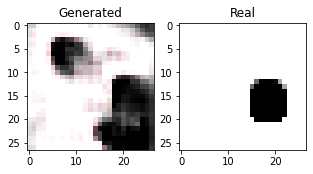

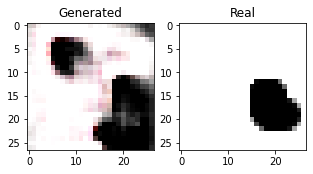

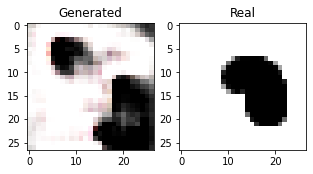

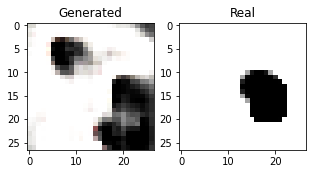

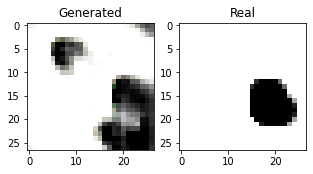

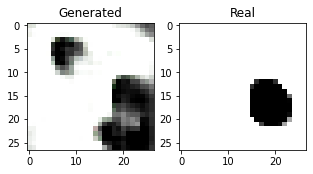

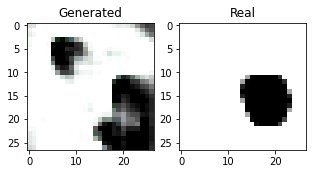

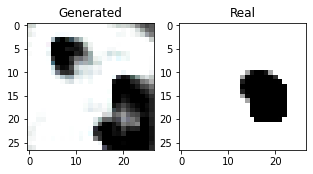

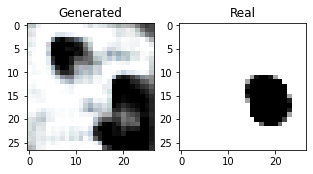

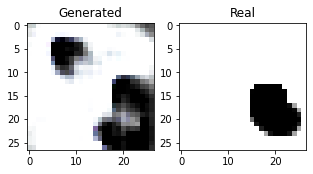

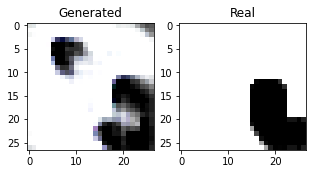

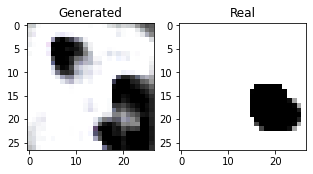

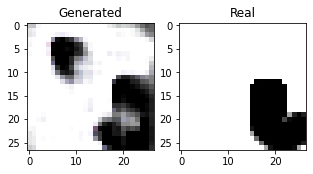

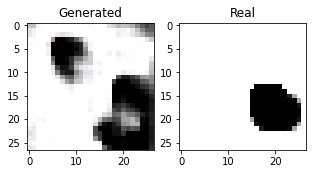

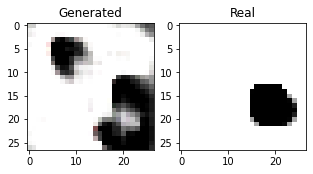

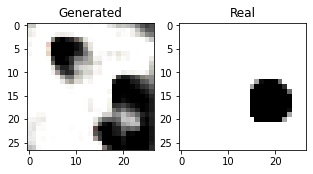

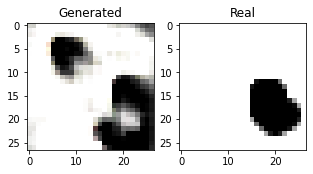

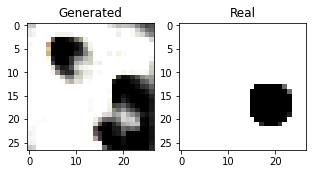

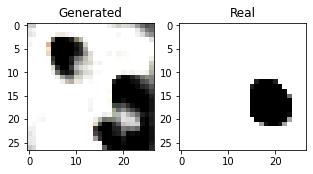

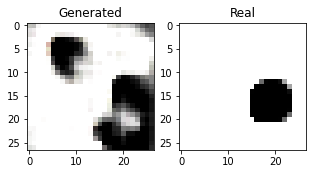

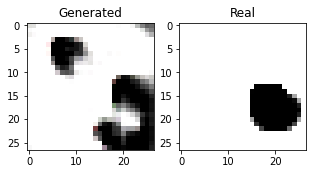

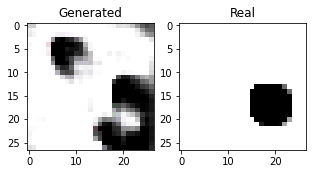

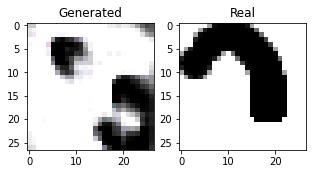

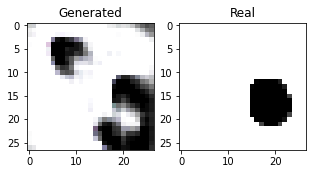

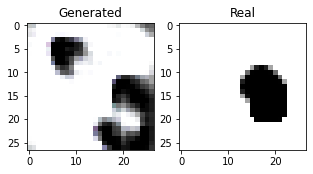

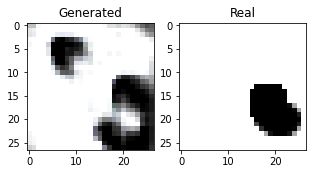

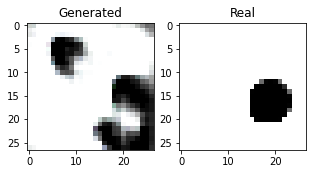

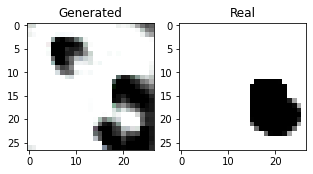

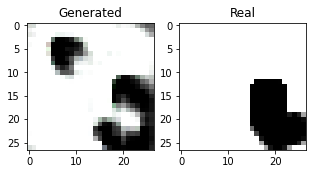

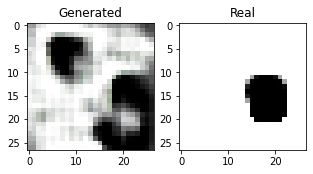

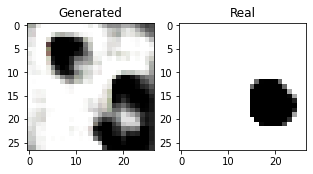

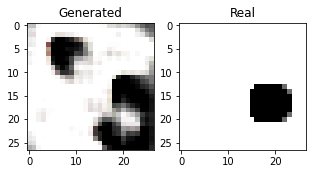

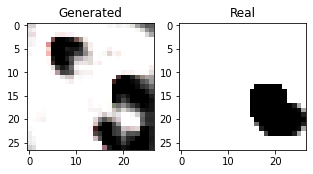

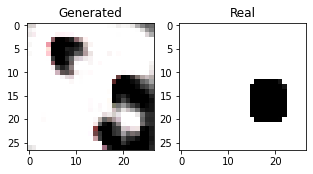

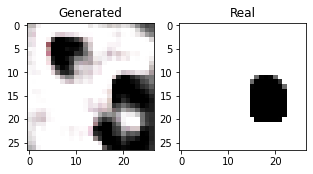

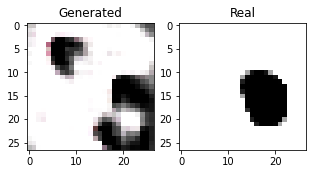

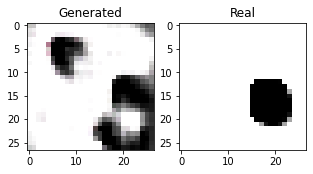

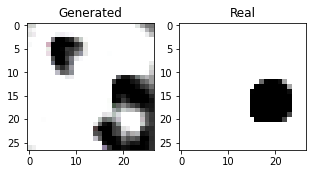

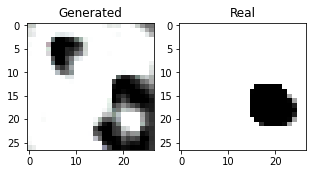

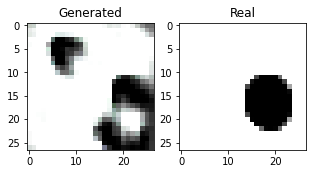

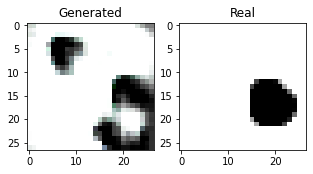

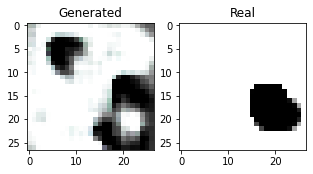

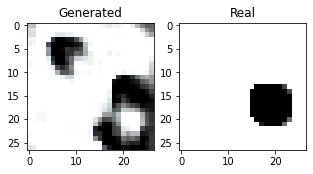

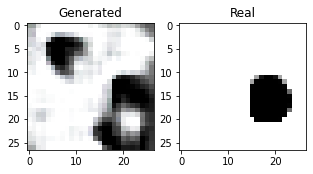

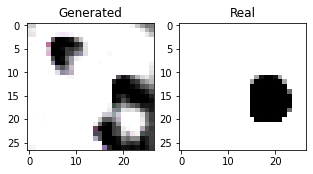

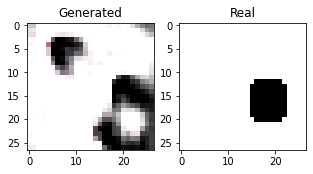

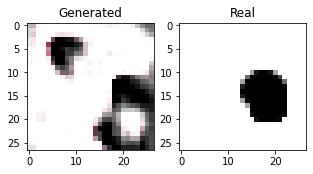

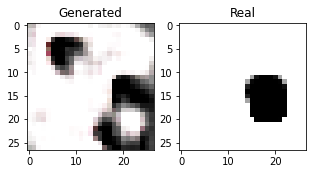

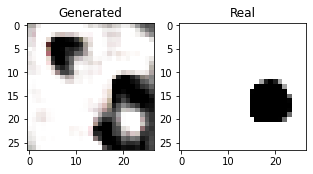

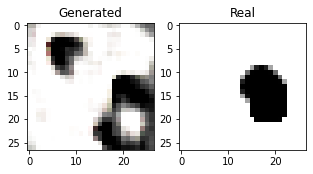

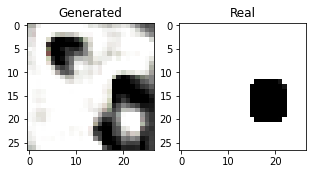

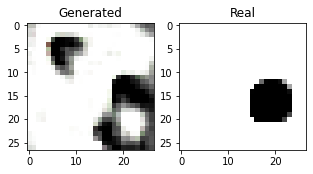

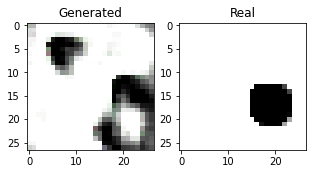

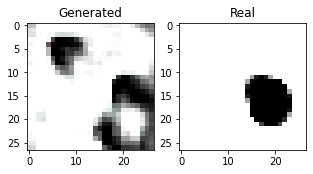

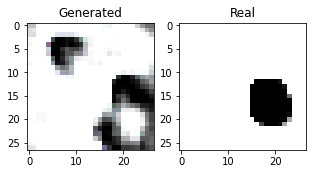

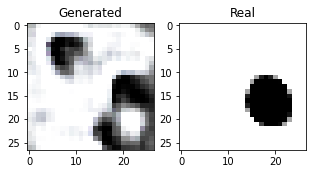

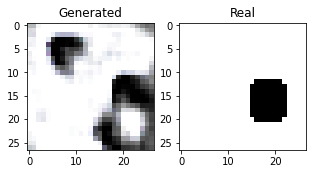

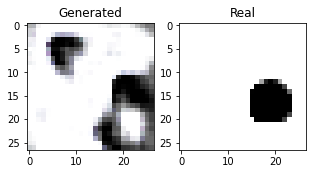

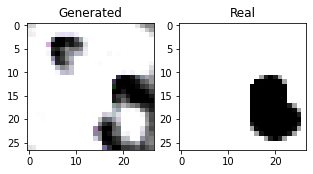

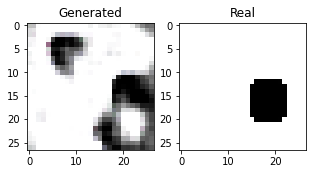

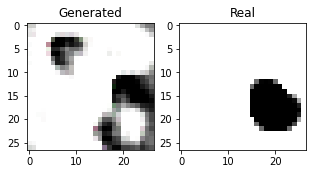

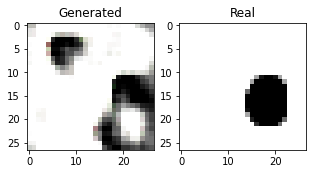

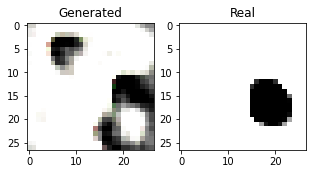

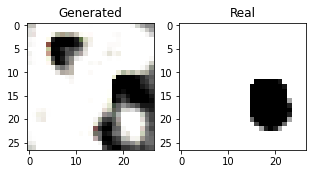

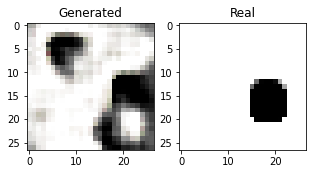

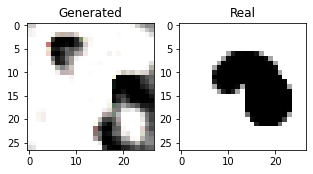

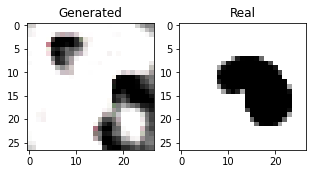

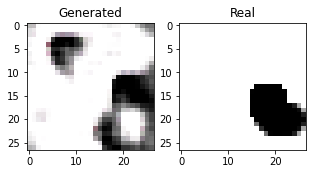

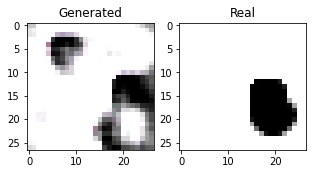

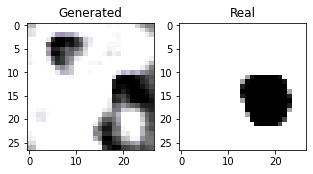

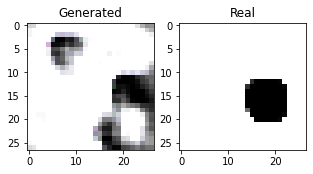

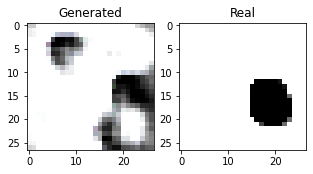

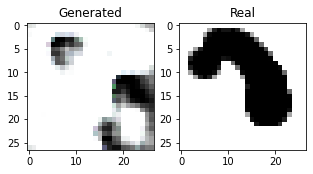

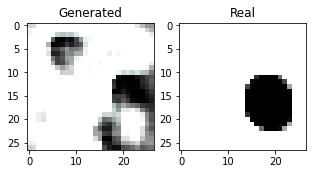

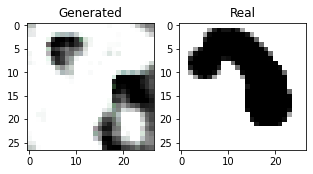

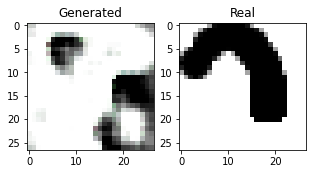

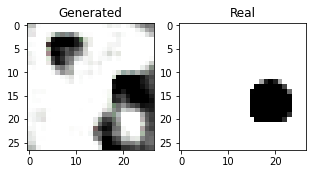

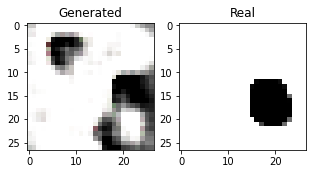

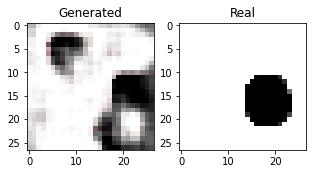

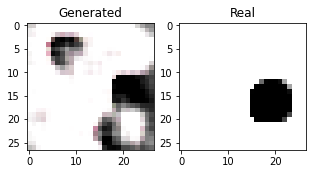

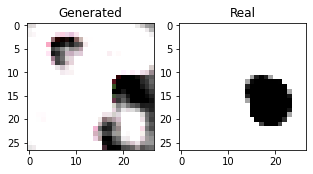

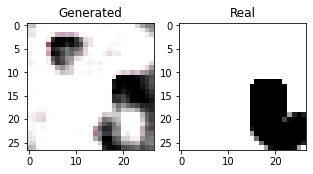

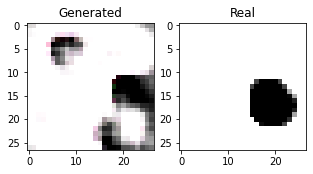

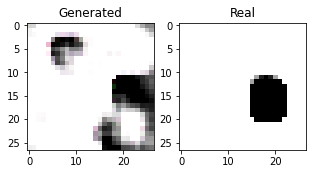

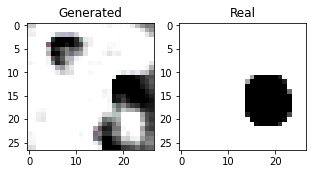

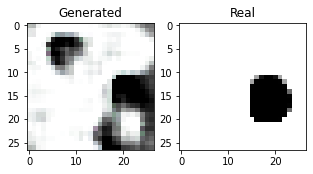

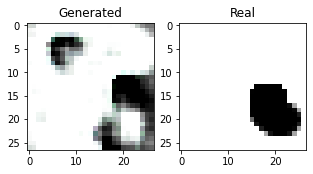

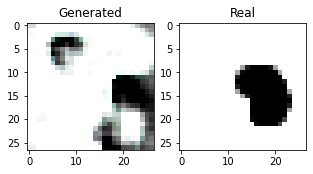

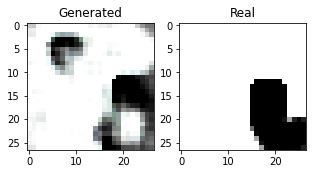

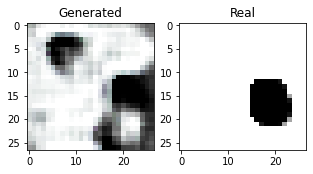

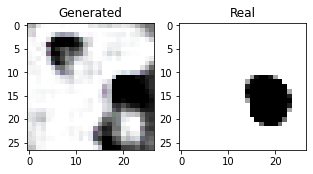

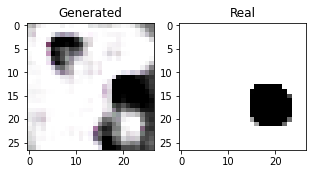

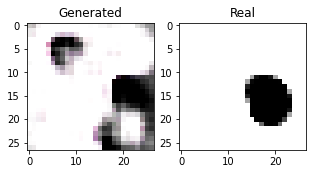

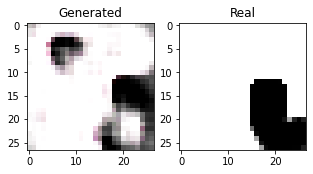

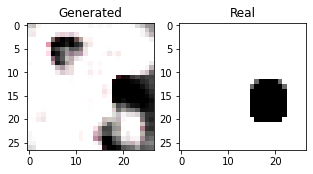

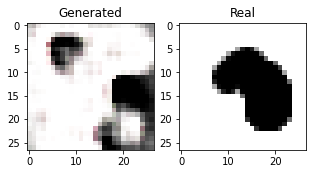

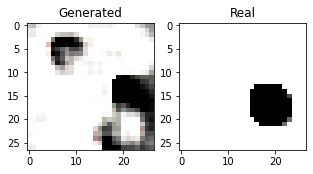

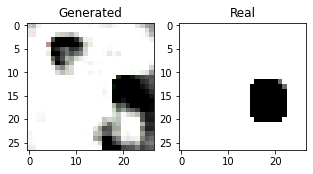

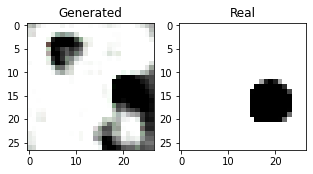

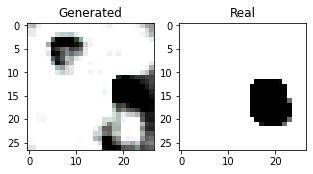

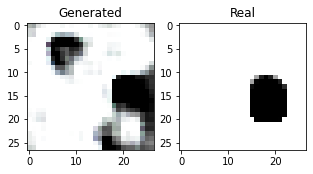

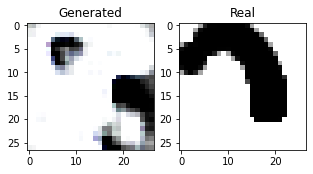

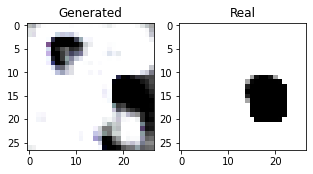

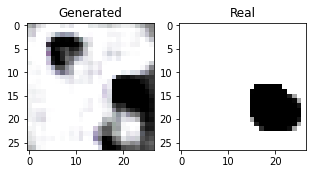

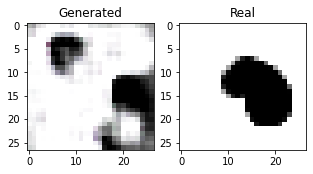

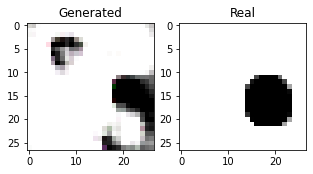

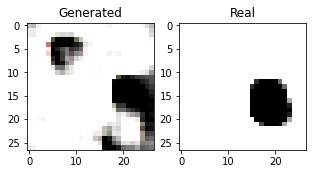

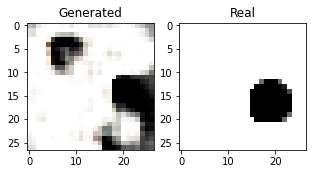

In [15]:
def reset_grad():
    generator.zero_grad()
    discriminator.zero_grad()

for epoch in range(config['epochs_num']):
    for _ in range(config['disc_coef']):  # TODO: (@whiteRa2bit, 2020-08-30) Replace with kwargs param
        # Sample data
        X = Variable(next(dataloader))
        X = X.to(config['device'])
        z = Variable(torch.rand(config['batch_size'], config['z_dim']))
        z = z.to(config['device'])

        # Dicriminator forward-loss-backward-update
        G_sample = generator(z)
        D_real = discriminator(X)
        D_fake = discriminator(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_optimizer.step()

        # # Weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)  # TODO: (@whiteRa2bit, 2020-08-30) Replace with kwargs param

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    X = Variable(next(dataloader))
    X = X.to(config['device'])
    z = Variable(torch.rand(config['batch_size'], config['z_dim']))
    z = z.to(config['device'])

    G_sample = generator(z)
    D_fake = discriminator(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_optimizer.step()

    # Housekeeping - reset gradient
    reset_grad()

    if epoch % config['log_each'] == 0:
        wandb.log({"D loss": D_loss.cpu().data, "G loss": G_loss.cpu().data.numpy()})

        generated_sample = G_sample[0].cpu().data
        generated_sample = np.array(generated_sample.permute(1, 2, 0))
        generated_sample[generated_sample > 1] = 1.0
        generated_sample[generated_sample < 0] = 0.0
        real_sample = X[0].cpu().data
        real_sample = np.array(real_sample.permute(1, 2, 0))
        
        f, ax = plt.subplots(1, 2, figsize=(5, 12))
        ax[0].set_title("Generated")
        ax[0].imshow(generated_sample)
        ax[1].set_title("Real")
        ax[1].imshow(real_sample)
        plt.show()

In [15]:
# torch.save(generator.state_dict(), 'generator.pt')
# torch.save(discriminator.state_dict(), 'discriminator.pt')